# Analysis of Gradient Boosting Results + Complexity Measures per Level of complexity

Now we have a total of 112 datasets. We want to split them according to their level of complexity and study the results in the different categories. The objective is to investigate if we obtain better results than classic boosting for some levels of complexity (for example, for the hardest datasets).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import math


os.chdir("..")
root_path = os.getcwd()

In [2]:
path_csv = os.path.join(root_path, 'Results_GB')
os.chdir(path_csv)

In [3]:
#colour_palette_personalized = ["#FFD700", "#00CED1", "#FF1493","#F1F1F1"]
colour_palette_personalized = {
    "classic": "#FFD700",   # yellow
    "sample_weight_easy": "#C7F7FF", # blue
    "sample_weight_easy_x2": "#00CED1", # blue
    "sample_weight_hard": "#FFB3DA",    # magenta
    "sample_weight_hard_x2": "#FF1493",    # magenta
    "Classic": "#FFD700",   # yellow
    "Easy": "#C7F7FF", # blue
     "Easy x2": "#00CED1", # blue
    "Hard": "#FFB3DA",    # magenta
     "Hard x2": "#FF1493"    # magenta
}



In [4]:
specific_path = os.path.join(path_csv, '*Aggregated*.csv')
selected_files = glob.glob(specific_path)
all_datasets = pd.concat([pd.read_csv(f) for f in selected_files], ignore_index=True)

We already have the complexity characteristics of each dataset in the csv complex_info_dataset_20250115.csv. We read it and split the datasets according to the complexity values of each complexity measure.

In [5]:
path_complex = os.path.join(root_path, 'datasets/complexity_info')
os.chdir(path_complex)
df_complex = pd.read_csv('complex_info_dataset_20250115.csv')
df_complex.head()

,dataset,Hostility,kDN,DS,DCP,TD_U,TD_P,MV,CB,CLD,N1,N2,LSC,LSradius,H,U,F1,F2,F3,F4
0,analcatdata_gviolence,0.229730,0.083784,0.219595,0.050778,0.489865,1.000000,0.116908,0.657901,0.187850,0.064189,0.249374,0.589575,0.608601,0.027027,0.600292,0.405405,0.000000,0.612981,0.911090
1,analcatdata_japansolvent,0.250000,0.265385,0.384615,0.000000,0.461538,0.461538,0.035613,0.666174,0.336514,0.247436,0.400943,0.768121,0.791536,0.038462,0.776809,0.766827,0.538542,0.757220,0.916458
2,analcatdata_vineyard,0.158120,0.188462,0.605078,0.493827,0.500986,NaN,0.088889,0.662551,0.418386,0.150641,0.245928,0.975808,0.948771,0.004274,0.975912,0.849003,0.736191,0.799548,0.862728
3,arrhythmia_cfs,0.205752,0.316372,0.573684,0.177085,0.572607,0.692232,0.071031,0.664311,0.331718,0.316758,0.471772,0.981821,0.715307,0.004425,0.981899,0.745515,0.603953,0.801924,0.989752
4,Australian,0.175362,0.185507,0.615459,0.211243,0.568237,0.761594,0.088288,0.662623,0.220640,0.192174,0.398111,0.969318,0.799725,0.002899,0.969406,0.519876,0.664697,0.757345,0.995492


In [6]:
list_CM = ['Hostility','kDN','DCP','TD_U','CLD','N1','N2','LSC','F1']

Para este análisis lo que voy a hacer es:
 * Dividir el rango de cada medida de complejidad en 3: fácil, medio, difícil. Esto lo haré automáticamente con alguna función de python puesto que para algunas medidas (por ejemplo, F1 cuyo rango es [0,1] pero con valores muy concentrados en torno al 0.9, no sé interpretar los valores).
  * Para cada medida de complejidad, estudiar los resultados en estos cortes. Miraré media, mediana y std de accuracy y el WTL.
  * Luego hago el estudio desde la otra perspectiva. Divido los datasets en función de si, con esa medida de complejidad, gano, empato o pierdo. Creo esas categorías y hago una análisis exploratorio de las mismas. Por ejemplo, grafico la complejidad de dichas categorías mediante boxplots.

In [7]:
# Cogemos la función WTL del otro script
def win_tie_loss_comparison_info_complexity(data, complexity_df, main_method, compare_method, loss_function, metric='test_acc_mean',
                                            n_ensemble_values=[10, 25, 50, 100, 150, 200, 250, 300]):
    """
    Realiza un análisis win-tie-loss comparando el método principal con otro método específico para cada medida de complejidad.

    Parameters:
    - data: DataFrame con las columnas ['dataset', 'n_ensemble', 'method_weights', 'compl_measure', metric]
    - main_method: método principal que se desea comparar (ejemplo: 'classic')
    - compare_method: método específico con el cual comparar el principal (ejemplo: 'init_easy')
    - metric: métrica de comparación (por defecto 'test_acc_mean')
    - n_ensemble_values: valores de n_ensemble a considerar

    Returns:
    - Una tabla con el conteo de wins, ties, y losses por cada valor de n_ensemble y medida de complejidad.
    """
    results = []
    # Crear una lista para almacenar los resultados
    all_results = []
    value_wtl = 'nada'

    for n in n_ensemble_values:
        # Filtrar los datos para el valor actual de n_ensemble
        subset_n = data[(data['n_ensemble'] == n) & (data['loss_selected'] == loss_function)]


        # Crear un diccionario para almacenar los resultados de esta combinación de n_ensemble
        row = {'n_ensemble': n}

        CM_list = subset_n['compl_measure'].unique()[1:] # to delete none

        for compl in CM_list:
            win, tie, loss = 0, 0, 0

            # Filtrar los datos para la medida de complejidad actual
            subset_compl = subset_n[subset_n['compl_measure'] == compl]
            #if (main_method == 'classic') or (compare_method == 'classic'):
            #     subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']

            for dataset in subset_compl['dataset'].unique():
                # Filtrar para el dataset y métod en cuestión

                if (main_method == 'classic'):
                    subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']
                    main_value = subset_compl_main[(subset_compl_main['dataset'] == dataset) & (subset_compl_main['method_weights'] == main_method)][metric].values
                else:
                    main_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == main_method)][metric].values
                if (compare_method == 'classic'):
                    subset_compl_compare = subset_n[subset_n['compl_measure'] == 'none']
                    compare_value = subset_compl_compare[(subset_compl_compare['dataset'] == dataset) & (subset_compl_compare['method_weights'] == compare_method)][metric].values
                else:
                    compare_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == compare_method)][metric].values

                # Verificar que tenemos valores únicos para cada dataset y métod
                if main_value.size > 0 and compare_value.size > 0:
                    main_value = main_value[0]
                    compare_value = compare_value[0]

                    # Comparación win-tie-loss
                    if main_value < compare_value:
                        win += 1
                        value_wtl = 'win'
                    elif main_value == compare_value:
                        tie += 1
                        value_wtl = 'tie'
                    else:
                        loss += 1
                        value_wtl = 'loss'

                # Obtener las medidas de complejidad para el dataset
                complexity_values = complexity_df[complexity_df['dataset'] == dataset][compl].values
                if complexity_values.size > 0:
                    complexity_value = complexity_values[0]

                    # Almacenar los resultados en una lista de diccionarios
                    all_results.append({
                        'n_ensemble': n,
                        'compl_measure': compl,
                        'result': value_wtl,
                        'complexity_value': complexity_value,
                        'dataset_name':dataset,
                        main_method:main_value,
                        compare_method:compare_value
                    })

            # Guardar el resultado para esta medida de complejidad en una columna específica
            row[f'{compare_method}_{compl}'] = (win, tie, loss)

        # Agregar el resultado de esta iteración a los resultados
        results.append(row)

    # Convertir los resultados a DataFrame
    win_tie_loss_df = pd.DataFrame(results)

    return win_tie_loss_df, all_results


In [82]:
#result_table = win_tie_loss_comparison(all_datasets, main_method='classic', compare_method='sample_weight_easy', loss_function='log_loss')
# exponential
#result_table

,n_ensemble,sample_weight_easy_Hostility,sample_weight_easy_kDN,sample_weight_easy_DCP,sample_weight_easy_TD_U,sample_weight_easy_CLD,sample_weight_easy_N1,sample_weight_easy_N2,sample_weight_easy_LSC,sample_weight_easy_F1
0,10,"(31, 22, 59)","(40, 28, 44)","(24, 28, 60)","(20, 26, 66)","(28, 24, 60)","(43, 27, 42)","(36, 21, 55)","(45, 20, 47)","(28, 31, 53)"
1,25,"(30, 18, 64)","(37, 16, 59)","(21, 19, 72)","(25, 16, 71)","(24, 14, 74)","(34, 17, 61)","(34, 16, 62)","(34, 14, 64)","(37, 16, 59)"
2,50,"(35, 9, 68)","(41, 12, 59)","(22, 13, 77)","(28, 13, 71)","(26, 13, 73)","(34, 15, 63)","(33, 15, 64)","(46, 11, 55)","(41, 15, 56)"
3,100,"(39, 11, 62)","(41, 12, 59)","(27, 18, 67)","(31, 14, 67)","(30, 13, 69)","(45, 16, 51)","(43, 11, 58)","(41, 14, 57)","(38, 18, 56)"
4,150,"(40, 13, 59)","(41, 14, 57)","(28, 12, 72)","(28, 14, 70)","(30, 9, 73)","(41, 14, 57)","(37, 15, 60)","(40, 13, 59)","(31, 18, 63)"
5,200,"(37, 13, 62)","(37, 17, 58)","(31, 13, 68)","(30, 14, 68)","(32, 15, 65)","(40, 19, 53)","(36, 16, 60)","(45, 15, 52)","(26, 16, 70)"
6,250,"(43, 12, 57)","(39, 19, 54)","(32, 14, 66)","(28, 17, 67)","(32, 12, 68)","(41, 17, 54)","(35, 18, 59)","(39, 13, 60)","(31, 18, 63)"
7,300,"(45, 16, 51)","(39, 19, 54)","(29, 15, 68)","(28, 16, 68)","(31, 14, 67)","(46, 15, 51)","(39, 15, 58)","(41, 12, 59)","(29, 16, 67)"


In [8]:
win_tie_loss_df, all_results = win_tie_loss_comparison_info_complexity(all_datasets, df_complex, main_method='classic', compare_method='sample_weight_easy',
                                                                       loss_function='log_loss')
win_tie_loss_df

,n_ensemble,sample_weight_easy_Hostility,sample_weight_easy_kDN,sample_weight_easy_DCP,sample_weight_easy_TD_U,sample_weight_easy_CLD,sample_weight_easy_N1,sample_weight_easy_N2,sample_weight_easy_LSC,sample_weight_easy_F1
0,10,"(31, 22, 59)","(40, 28, 44)","(24, 28, 60)","(20, 26, 66)","(28, 24, 60)","(43, 27, 42)","(36, 21, 55)","(45, 20, 47)","(28, 31, 53)"
1,25,"(30, 18, 64)","(37, 16, 59)","(21, 19, 72)","(25, 16, 71)","(24, 14, 74)","(34, 17, 61)","(34, 16, 62)","(34, 14, 64)","(37, 16, 59)"
2,50,"(35, 9, 68)","(41, 12, 59)","(22, 13, 77)","(28, 13, 71)","(26, 13, 73)","(34, 15, 63)","(33, 15, 64)","(46, 11, 55)","(41, 15, 56)"
3,100,"(39, 11, 62)","(41, 12, 59)","(27, 18, 67)","(31, 14, 67)","(30, 13, 69)","(45, 16, 51)","(43, 11, 58)","(41, 14, 57)","(38, 18, 56)"
4,150,"(40, 13, 59)","(41, 14, 57)","(28, 12, 72)","(28, 14, 70)","(30, 9, 73)","(41, 14, 57)","(37, 15, 60)","(40, 13, 59)","(31, 18, 63)"
5,200,"(37, 13, 62)","(37, 17, 58)","(31, 13, 68)","(30, 14, 68)","(32, 15, 65)","(40, 19, 53)","(36, 16, 60)","(45, 15, 52)","(26, 16, 70)"
6,250,"(43, 12, 57)","(39, 19, 54)","(32, 14, 66)","(28, 17, 67)","(32, 12, 68)","(41, 17, 54)","(35, 18, 59)","(39, 13, 60)","(31, 18, 63)"
7,300,"(45, 16, 51)","(39, 19, 54)","(29, 15, 68)","(28, 16, 68)","(31, 14, 67)","(46, 15, 51)","(39, 15, 58)","(41, 12, 59)","(29, 16, 67)"


In [9]:
# Función para categorizar en tres niveles
def categorize_column(column):
    min_val = column.min()
    max_val = column.max()
    thresholds = np.linspace(min_val, max_val, 4)  # Dividimos el rango en 3 categorías
    return pd.cut(
        column,
        bins=thresholds,
        labels=["low", "medium", "high"],
        include_lowest=True
    )

In [12]:
def summary_CM_complexity_dataset(CM,dataset,df_complexity, loss_function): #dataset es all_datasets
    # nos quedamos con las filas referentes a la CM en particular, al modo clásico
    # y con la función de pérdida escogida
    all_datasets_CM = dataset.loc[((dataset.compl_measure == CM) | (dataset.compl_measure == 'none')) & (dataset.loss_selected == loss_function),:]

    df_complexity2 = df_complexity.copy()

    # Complejidad de los datasets
    for col in df_complexity2.columns[1:]:  # Excluye la columna 'dataset'
        df_complexity2[f'cat_{col}'] = categorize_column(df_complexity2[col])

    # We introduce the complexity of all datasets in the main df
    df_merged = all_datasets_CM.merge(df_complexity2[['dataset', 'cat_'+CM]], on='dataset', how='left')

    # Filtrar en función de 'cat_CMi'
    df_low_CM = df_merged[df_merged['cat_'+CM] == 'low']
    df_medium_CM = df_merged[df_merged['cat_'+CM] == 'medium']
    df_high_CM = df_merged[df_merged['cat_'+CM] == 'high']

    summary_results_low = df_low_CM.groupby(['dataset', 'method_weights']).agg(
        test_acc_mean_median=('test_acc_mean', 'median'),
        test_acc_mean_std=('test_acc_mean', 'std'),
        test_acc_mean_total_mean=('test_acc_mean', 'mean')
    ).reset_index()

    summary_results_medium = df_medium_CM.groupby(['dataset', 'method_weights']).agg(
        test_acc_mean_median=('test_acc_mean', 'median'),
        test_acc_mean_std=('test_acc_mean', 'std'),
        test_acc_mean_total_mean=('test_acc_mean', 'mean')
    ).reset_index()

    summary_results_high = df_high_CM.groupby(['dataset', 'method_weights']).agg(
        test_acc_mean_median=('test_acc_mean', 'median'),
        test_acc_mean_std=('test_acc_mean', 'std'),
        test_acc_mean_total_mean=('test_acc_mean', 'mean')
    ).reset_index()

    # Pivotar para obtener una tabla más organizada
    summary_pivot_low = summary_results_low.pivot(index='dataset', columns='method_weights',
                                          values=['test_acc_mean_median', 'test_acc_mean_std', 'test_acc_mean_total_mean'])

    summary_pivot_medium = summary_results_medium.pivot(index='dataset', columns='method_weights',
                                          values=['test_acc_mean_median', 'test_acc_mean_std', 'test_acc_mean_total_mean'])

    summary_pivot_high = summary_results_high.pivot(index='dataset', columns='method_weights',
                                          values=['test_acc_mean_median', 'test_acc_mean_std', 'test_acc_mean_total_mean'])

    # Renombrar columnas para que sean más fáciles de leer
    summary_pivot_low.columns = [f'{method}_{stat}' for stat, method in summary_pivot_low.columns]
    summary_pivot_low.reset_index(inplace=True)
    summary_pivot_medium.columns = [f'{method}_{stat}' for stat, method in summary_pivot_medium.columns]
    summary_pivot_medium.reset_index(inplace=True)
    summary_pivot_high.columns = [f'{method}_{stat}' for stat, method in summary_pivot_high.columns]
    summary_pivot_high.reset_index(inplace=True)


    ###----- WTL analysis -----###
    wtl_sw_easy_low, _ = win_tie_loss_comparison_info_complexity(df_low_CM, df_complexity, main_method='classic', compare_method='sample_weight_easy',
                                                                       loss_function=loss_function)
    wtl_sw_easy_medium, _ = win_tie_loss_comparison_info_complexity(df_medium_CM, df_complexity, main_method='classic', compare_method='sample_weight_easy', loss_function=loss_function)
    wtl_sw_easy_high, _ = win_tie_loss_comparison_info_complexity(df_high_CM, df_complexity, main_method='classic', compare_method='sample_weight_easy', loss_function=loss_function)

    wtl_sw_hard_low, _ = win_tie_loss_comparison_info_complexity(df_low_CM, df_complexity, main_method='classic', compare_method='sample_weight_hard',
    loss_function=loss_function)
    wtl_sw_hard_medium, _ = win_tie_loss_comparison_info_complexity(df_medium_CM, df_complexity, main_method='classic', compare_method='sample_weight_hard', loss_function=loss_function)
    wtl_sw_hard_high, _ = win_tie_loss_comparison_info_complexity(df_high_CM, df_complexity, main_method='classic', compare_method='sample_weight_hard', loss_function=loss_function)


    ###------  Plots  ------###
    # Low complexity dataset
    summary_long_low = summary_pivot_low.melt(id_vars='dataset',
                                         value_vars=[
                                            'classic_test_acc_mean_median',
                                            'sample_weight_easy_test_acc_mean_median',
                                            'sample_weight_hard_test_acc_mean_median',
                                             'sample_weight_easy_x2_test_acc_mean_median',
                                            'sample_weight_hard_x2_test_acc_mean_median',
                                            'classic_test_acc_mean_std',
                                            'sample_weight_easy_test_acc_mean_std',
                                            'sample_weight_hard_test_acc_mean_std',
                                            'sample_weight_easy_x2_test_acc_mean_std',
                                            'sample_weight_hard_x2_test_acc_mean_std',
                                            'classic_test_acc_mean_total_mean',
                                            'sample_weight_easy_test_acc_mean_total_mean',
                                            'sample_weight_hard_test_acc_mean_total_mean',
                                             'sample_weight_easy_x2_test_acc_mean_total_mean',
                                            'sample_weight_hard_x2_test_acc_mean_total_mean'
                                        ],
                                        var_name='method_stat',
                                        value_name='value')

    # Separar los nombres de métod y estadístico
    summary_long_low[['method', 'statistic']] = summary_long_low['method_stat'].str.rsplit('_', n=1, expand=True)
    summary_long_low['method'] = summary_long_low['method'].replace({
         'classic_test_acc_mean': 'Classic',
        'sample_weight_easy_test_acc_mean': 'Easy',
        'sample_weight_easy_x2_test_acc_mean': 'Easy x2',
        'sample_weight_hard_test_acc_mean': 'Hard',
        'sample_weight_hard_x2_test_acc_mean': 'Hard x2',
        'classic_test_acc_mean_total': 'Classic',
        'sample_weight_easy_test_acc_mean_total': 'Easy',
        'sample_weight_easy_x2_test_acc_mean_total': 'Easy x2',
        'sample_weight_hard_test_acc_mean_total': 'Hard',
        'sample_weight_hard_x2_test_acc_mean_total': 'Hard x2'
    })


    # Crear un boxplot para cada estadístico
    plt.figure(figsize=(12, 5))

    # Usar un bucle para crear un boxplot por cada estadístico
    for i, stat in enumerate(summary_long_low['statistic'].unique(), start=1):
        plt.subplot(1, 3, i)  # 3 filas, 1 columna
        sns.boxplot(data=summary_long_low[summary_long_low['statistic'] == stat],
                     x='method',
                     y='value',
                     palette=colour_palette_personalized)

        plt.xlabel('Method')
        plt.ylabel(stat.capitalize())

    # Título global para el gráfico
    plt.suptitle('Boxplots of Summary Statistics Low complexity Datasets '+CM, fontsize=16)


    plt.tight_layout()
    plt.show()

    print('Low complexity datasets: WTL Classic vs sw_easy')
    print(wtl_sw_easy_low)
    print('Low complexity datasets: WTL Classic vs sw_hard')
    print(wtl_sw_hard_low)


    # Medium complexity dataset
    summary_long_medium = summary_pivot_medium.melt(id_vars='dataset',
                                         value_vars=[
                                            'classic_test_acc_mean_median',
                                            'sample_weight_easy_test_acc_mean_median',
                                            'sample_weight_hard_test_acc_mean_median',
                                             'sample_weight_easy_x2_test_acc_mean_median',
                                            'sample_weight_hard_x2_test_acc_mean_median',
                                            'classic_test_acc_mean_std',
                                            'sample_weight_easy_test_acc_mean_std',
                                            'sample_weight_hard_test_acc_mean_std',
                                            'sample_weight_easy_x2_test_acc_mean_std',
                                            'sample_weight_hard_x2_test_acc_mean_std',
                                            'classic_test_acc_mean_total_mean',
                                            'sample_weight_easy_test_acc_mean_total_mean',
                                            'sample_weight_hard_test_acc_mean_total_mean',
                                             'sample_weight_easy_x2_test_acc_mean_total_mean',
                                            'sample_weight_hard_x2_test_acc_mean_total_mean'
                                        ],
                                        var_name='method_stat',
                                        value_name='value')

    # Separar los nombres de métod y estadístico
    summary_long_medium[['method', 'statistic']] = summary_long_medium['method_stat'].str.rsplit('_', n=1, expand=True)
    summary_long_medium['method'] = summary_long_medium['method'].replace({
         'classic_test_acc_mean': 'Classic',
        'sample_weight_easy_test_acc_mean': 'Easy',
        'sample_weight_easy_x2_test_acc_mean': 'Easy x2',
        'sample_weight_hard_test_acc_mean': 'Hard',
        'sample_weight_hard_x2_test_acc_mean': 'Hard x2',
        'classic_test_acc_mean_total': 'Classic',
        'sample_weight_easy_test_acc_mean_total': 'Easy',
        'sample_weight_easy_x2_test_acc_mean_total': 'Easy x2',
        'sample_weight_hard_test_acc_mean_total': 'Hard',
        'sample_weight_hard_x2_test_acc_mean_total': 'Hard x2'
    })


    # Crear un boxplot para cada estadístico
    plt.figure(figsize=(12, 5))

    # Usar un bucle para crear un boxplot por cada estadístico
    for i, stat in enumerate(summary_long_medium['statistic'].unique(), start=1):
        plt.subplot(1, 3, i)  # 3 filas, 1 columna
        sns.boxplot(data=summary_long_medium[summary_long_medium['statistic'] == stat],
                     x='method',
                     y='value',
                     palette=colour_palette_personalized)

        plt.xlabel('Method')
        plt.ylabel(stat.capitalize())

    # Título global para el gráfico
    plt.suptitle('Boxplots of Summary Statistics Medium complexity Datasets '+CM, fontsize=16)


    plt.tight_layout()
    plt.show()

    print('Medium complexity datasets: WTL Classic vs sw_easy')
    print(wtl_sw_easy_medium)
    print('Medium complexity datasets: WTL Classic vs sw_hard')
    print(wtl_sw_hard_medium)



    # High complexity
    summary_long_high = summary_pivot_high.melt(id_vars='dataset',
                                         value_vars=[
                                            'classic_test_acc_mean_median',
                                            'sample_weight_easy_test_acc_mean_median',
                                            'sample_weight_hard_test_acc_mean_median',
                                             'sample_weight_easy_x2_test_acc_mean_median',
                                            'sample_weight_hard_x2_test_acc_mean_median',
                                            'classic_test_acc_mean_std',
                                            'sample_weight_easy_test_acc_mean_std',
                                            'sample_weight_hard_test_acc_mean_std',
                                            'sample_weight_easy_x2_test_acc_mean_std',
                                            'sample_weight_hard_x2_test_acc_mean_std',
                                            'classic_test_acc_mean_total_mean',
                                            'sample_weight_easy_test_acc_mean_total_mean',
                                            'sample_weight_hard_test_acc_mean_total_mean',
                                             'sample_weight_easy_x2_test_acc_mean_total_mean',
                                            'sample_weight_hard_x2_test_acc_mean_total_mean'
                                        ],
                                        var_name='method_stat',
                                        value_name='value')

    # Separar los nombres de métod y estadístico
    summary_long_high[['method', 'statistic']] = summary_long_high['method_stat'].str.rsplit('_', n=1, expand=True)
    summary_long_high['method'] = summary_long_high['method'].replace({
        'classic_test_acc_mean': 'Classic',
        'sample_weight_easy_test_acc_mean': 'Easy',
        'sample_weight_easy_x2_test_acc_mean': 'Easy x2',
        'sample_weight_hard_test_acc_mean': 'Hard',
        'sample_weight_hard_x2_test_acc_mean': 'Hard x2',
        'classic_test_acc_mean_total': 'Classic',
        'sample_weight_easy_test_acc_mean_total': 'Easy',
        'sample_weight_easy_x2_test_acc_mean_total': 'Easy x2',
        'sample_weight_hard_test_acc_mean_total': 'Hard',
        'sample_weight_hard_x2_test_acc_mean_total': 'Hard x2'
    })


    # Crear un boxplot para cada estadístico
    plt.figure(figsize=(12, 5))

    # Usar un bucle para crear un boxplot por cada estadístico
    for i, stat in enumerate(summary_long_high['statistic'].unique(), start=1):
        plt.subplot(1, 3, i)  # 3 filas, 1 columna
        sns.boxplot(data=summary_long_high[summary_long_high['statistic'] == stat],
                     x='method',
                     y='value',
                     palette=colour_palette_personalized)

        plt.xlabel('Method')
        plt.ylabel(stat.capitalize())

    # Título global para el gráfico
    plt.suptitle('Boxplots of Summary Statistics High complexity Datasets '+CM, fontsize=16)


    plt.tight_layout()
    plt.show()

    print('High complexity datasets: WTL Classic vs sw_easy')
    print(wtl_sw_easy_high)
    print('High complexity datasets: WTL Classic vs sw_hard')
    print(wtl_sw_hard_high)



    return summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high


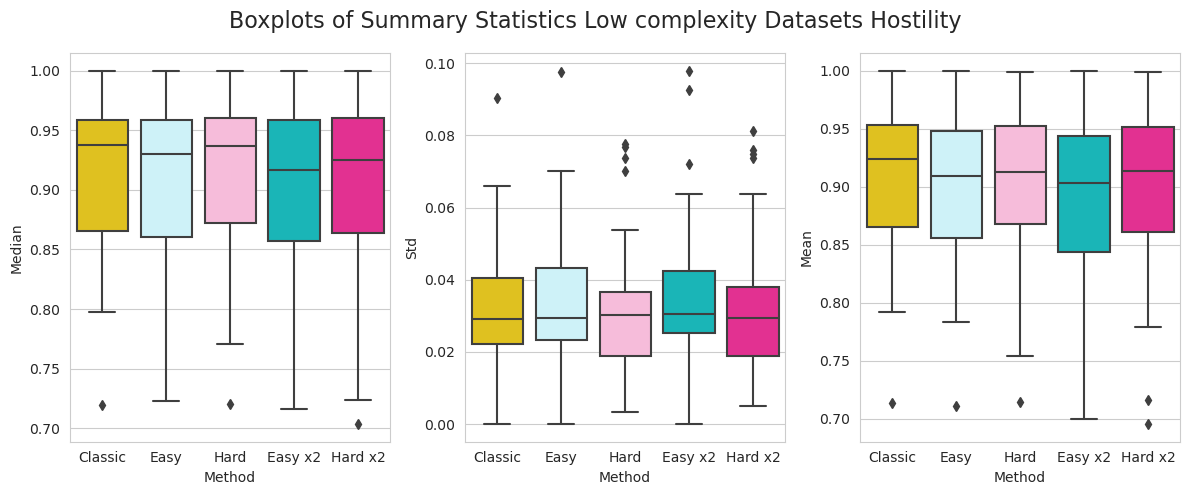

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                  (7, 11, 15)
1          25                   (9, 6, 18)
2          50                   (8, 7, 18)
3         100                   (8, 9, 16)
4         150                   (8, 8, 17)
5         200                   (7, 7, 19)
6         250                   (7, 7, 19)
7         300                  (10, 8, 15)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0          10                  (13, 6, 14)
1          25                  (12, 7, 14)
2          50                 (11, 11, 11)
3         100                  (11, 6, 16)
4         150                  (10, 7, 16)
5         200                  (14, 7, 12)
6         250                 (10, 10, 13)
7         300                   (9, 8, 16)


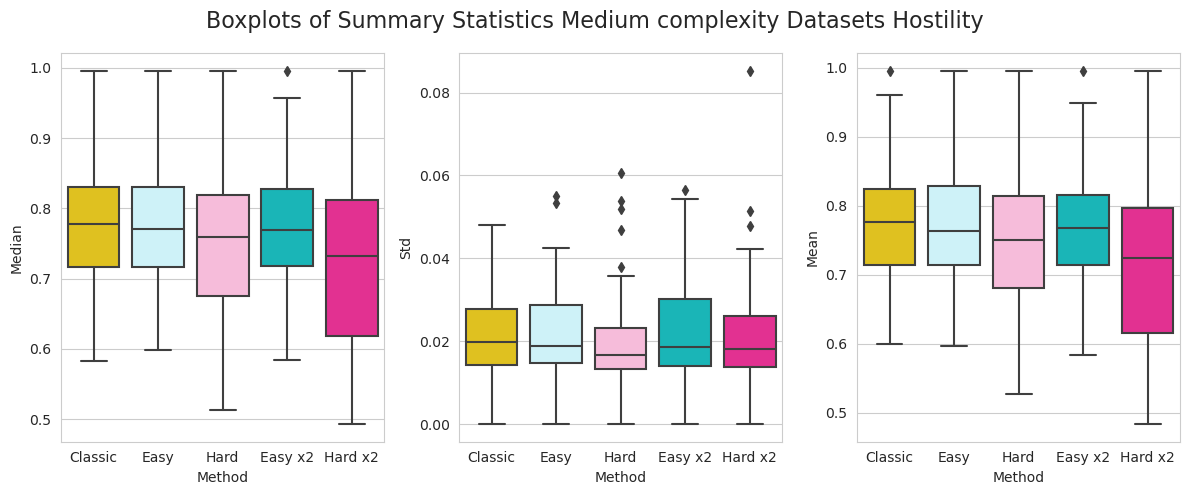

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                 (10, 11, 26)
1          25                  (12, 8, 27)
2          50                  (15, 5, 27)
3         100                  (16, 6, 25)
4         150                  (19, 5, 23)
5         200                  (23, 3, 21)
6         250                  (20, 5, 22)
7         300                  (23, 5, 19)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0          10                 (12, 12, 23)
1          25                   (9, 5, 33)
2          50                   (9, 4, 34)
3         100                  (11, 6, 30)
4         150                   (9, 3, 35)
5         200                   (8, 5, 34)
6         250                   (6, 5, 36)
7         300                   (5, 5, 37)


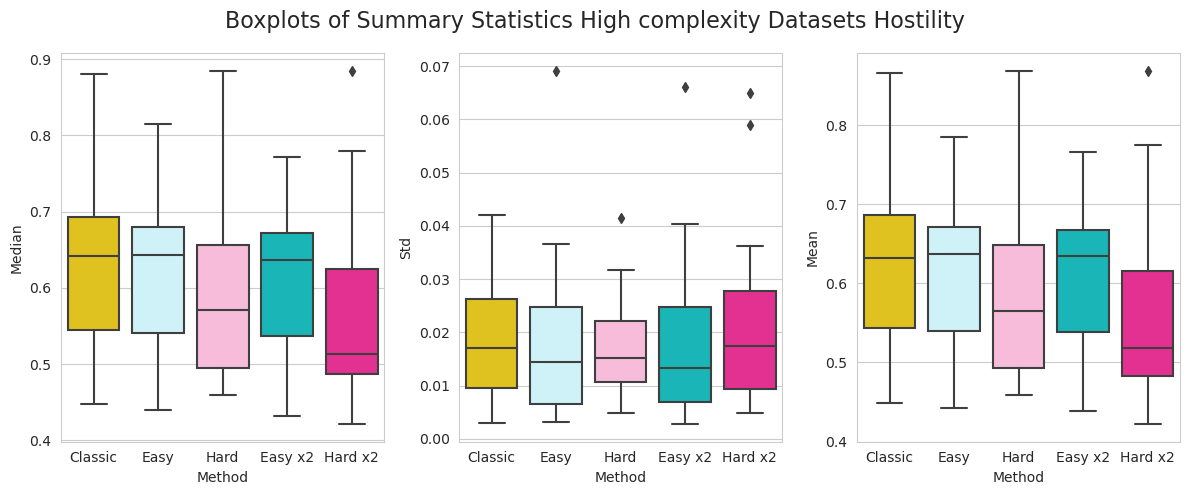

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                  (14, 3, 15)
1          25                  (13, 0, 19)
2          50                  (11, 3, 18)
3         100                  (11, 1, 20)
4         150                  (10, 1, 21)
5         200                  (13, 2, 17)
6         250                  (12, 2, 18)
7         300                  (12, 0, 20)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0          10                  (10, 1, 21)
1          25                   (7, 0, 25)
2          50                   (7, 1, 24)
3         100                   (4, 0, 28)
4         150                   (4, 0, 28)
5         200                   (5, 0, 27)
6         250                   (7, 1, 24)
7         300                   (6, 1, 25)


In [13]:
CM = 'Hostility'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

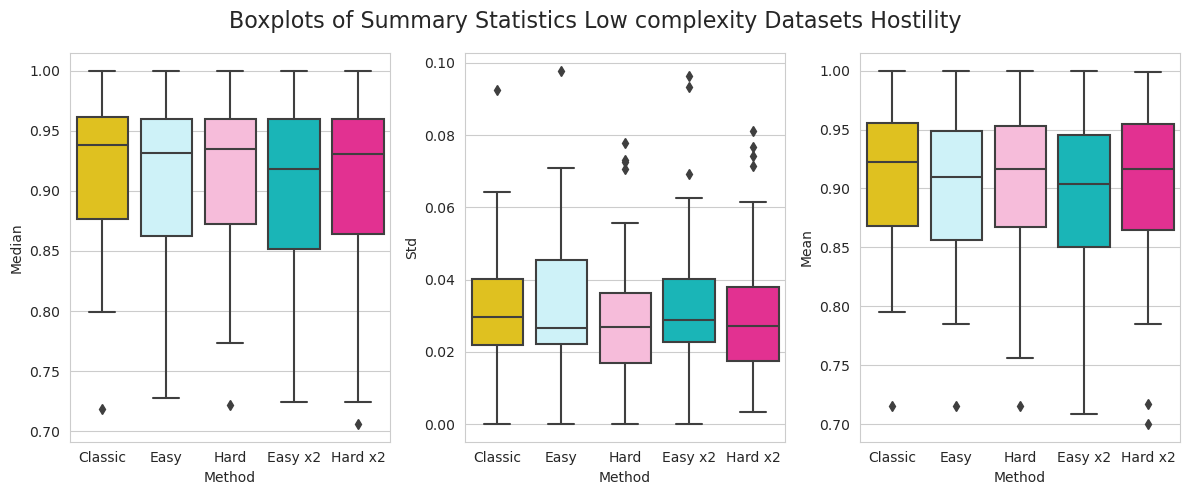

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                   (9, 9, 15)
1          25                   (7, 8, 18)
2          50                   (8, 6, 19)
3         100                   (8, 6, 19)
4         150                   (8, 7, 18)
5         200                   (8, 7, 18)
6         250                   (8, 7, 18)
7         300                   (8, 8, 17)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0          10                  (12, 8, 13)
1          25                   (17, 7, 9)
2          50                  (10, 8, 15)
3         100                   (9, 8, 16)
4         150                  (8, 12, 13)
5         200                   (9, 8, 16)
6         250                   (8, 8, 17)
7         300                   (9, 8, 16)


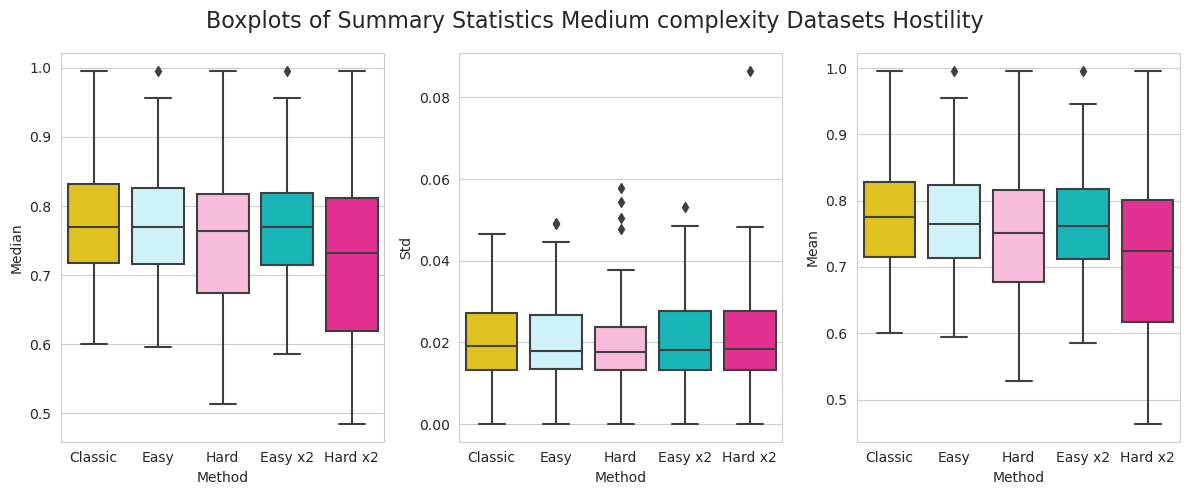

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                  (9, 10, 28)
1          25                  (11, 8, 28)
2          50                  (17, 3, 27)
3         100                  (19, 3, 25)
4         150                  (19, 6, 22)
5         200                  (18, 4, 25)
6         250                  (21, 5, 21)
7         300                  (20, 6, 21)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0          10                  (11, 9, 27)
1          25                   (6, 3, 38)
2          50                  (10, 4, 33)
3         100                  (12, 4, 31)
4         150                   (9, 3, 35)
5         200                   (5, 4, 38)
6         250                   (6, 4, 37)
7         300                   (6, 4, 37)


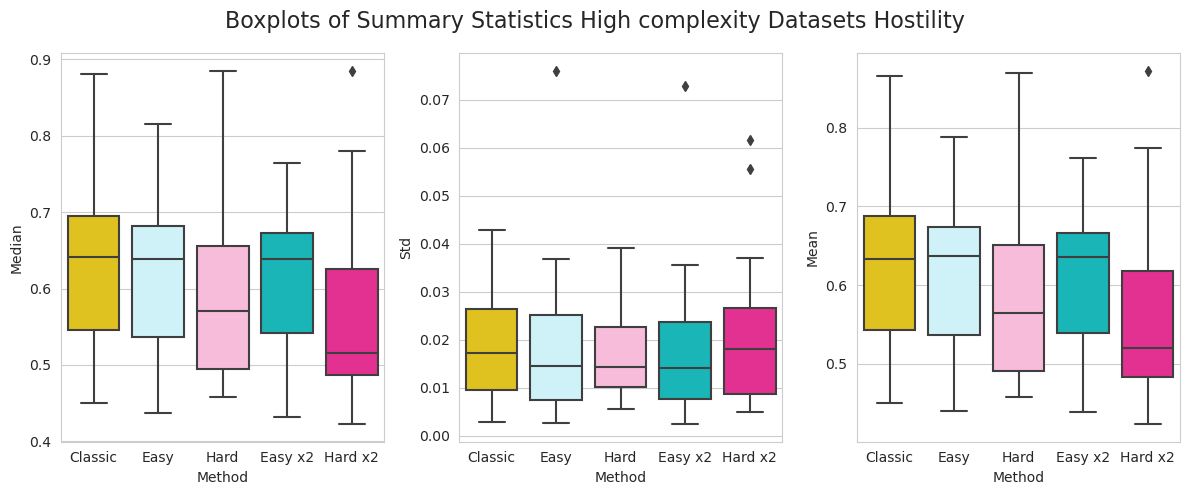

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_Hostility
0          10                  (13, 3, 16)
1          25                  (12, 2, 18)
2          50                  (10, 0, 22)
3         100                  (12, 2, 18)
4         150                  (13, 0, 19)
5         200                  (11, 2, 19)
6         250                  (14, 0, 18)
7         300                  (17, 2, 13)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_Hostility
0          10                  (11, 1, 20)
1          25                   (8, 0, 24)
2          50                   (7, 1, 24)
3         100                   (3, 0, 29)
4         150                   (6, 1, 25)
5         200                   (5, 0, 27)
6         250                   (6, 1, 25)
7         300                   (7, 0, 25)


In [14]:
CM = 'Hostility'
loss_function = 'log_loss'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

**Hostilidad**

* En conjuntos de datos fáciles (33 según la hostilidad), lo que mejor resultados ofrece es sample_weight_hard. Cercano en mediana al GB clásico y por detrás en media. Std menor para nosotros. En WTL con hard vemos que gana clásica pero en un 40-60.

* En los de dificultad media (47), lo mejor sería Easy pero muy igualado con classic, en WTL vemos que en general gana classic, pero a partir de 150 ensembles ganaríamos nosotros o estaríamos muy en empate con easy. Sigue ganando en general Classic GB.

* En los datasets difíciles (32), nuestra mejor propuesta es Easy (aunque obtiene máximo mayor Hard), sigue ganando classic. En el WTL estamos con easy en un 33-66.

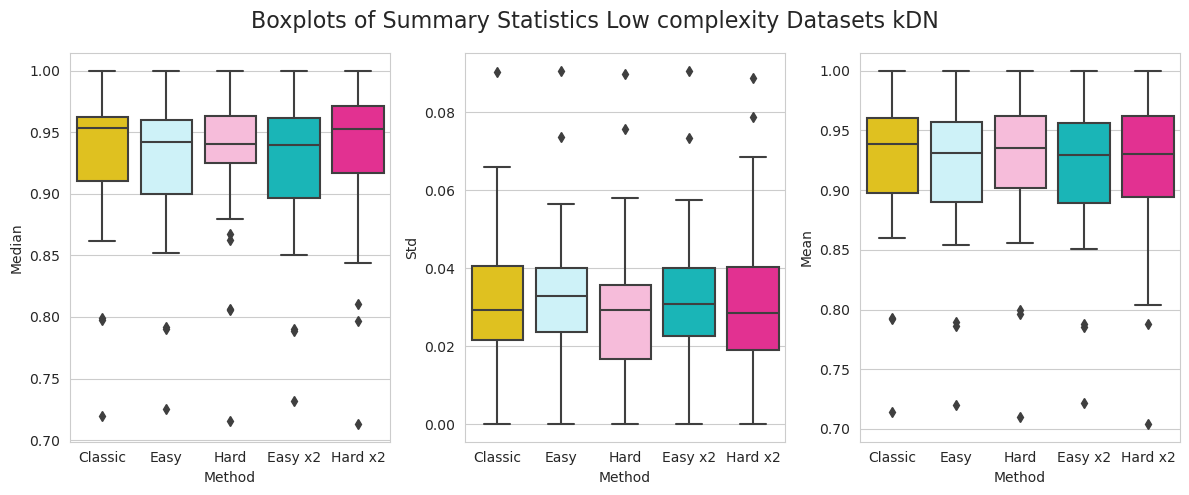

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_kDN
0          10             (8, 12, 9)
1          25             (6, 8, 15)
2          50             (3, 9, 17)
3         100             (6, 8, 15)
4         150             (5, 9, 15)
5         200            (5, 10, 14)
6         250            (4, 12, 13)
7         300            (6, 11, 12)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_kDN
0          10            (10, 10, 9)
1          25            (10, 8, 11)
2          50             (15, 8, 6)
3         100            (11, 11, 7)
4         150            (11, 12, 6)
5         200            (11, 11, 7)
6         250             (9, 12, 8)
7         300             (8, 13, 8)


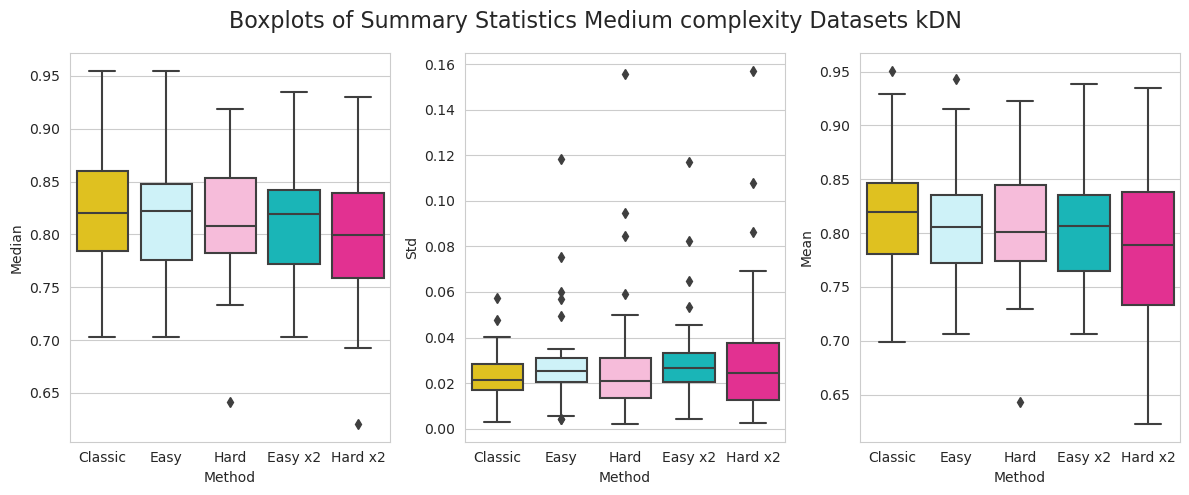

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_kDN
0          10            (7, 10, 17)
1          25             (8, 9, 17)
2          50            (13, 3, 18)
3         100            (12, 1, 21)
4         150            (12, 4, 18)
5         200            (15, 4, 15)
6         250            (11, 5, 18)
7         300            (15, 4, 15)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_kDN
0          10             (8, 8, 18)
1          25             (7, 3, 24)
2          50            (12, 3, 19)
3         100             (7, 4, 23)
4         150             (9, 1, 24)
5         200             (8, 4, 22)
6         250             (5, 6, 23)
7         300             (6, 5, 23)


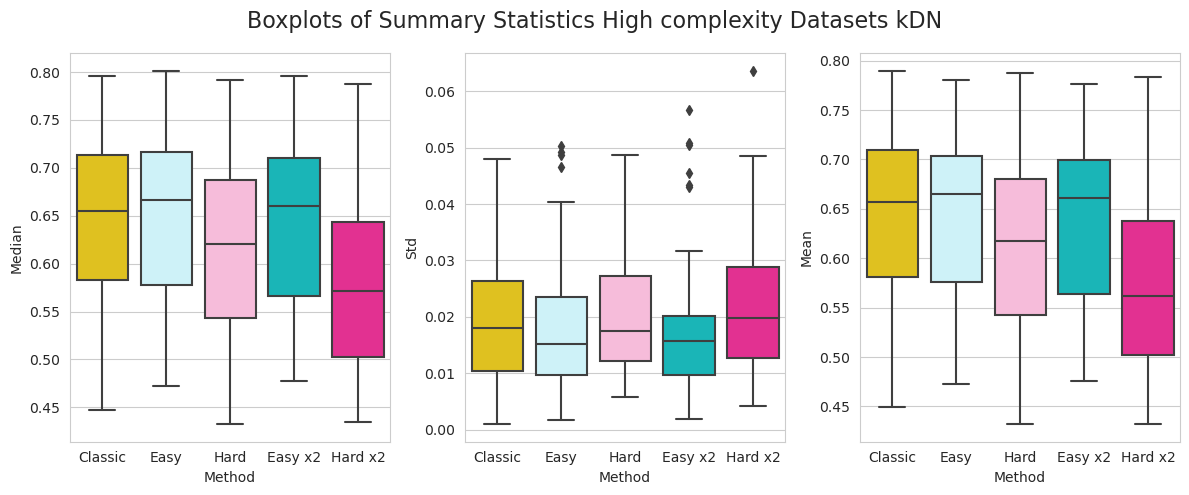

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_kDN
0          10           (20, 10, 19)
1          25            (27, 3, 19)
2          50            (27, 0, 22)
3         100            (26, 4, 19)
4         150            (25, 1, 23)
5         200            (20, 3, 26)
6         250            (22, 4, 23)
7         300            (24, 1, 24)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_kDN
0          10            (15, 2, 32)
1          25            (10, 1, 38)
2          50             (9, 2, 38)
3         100             (6, 1, 42)
4         150             (8, 1, 40)
5         200             (6, 3, 40)
6         250             (7, 2, 40)
7         300             (7, 0, 42)


In [15]:
CM = 'kDN'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

**kDN**

  * En los fáciles (29), lo mejor es Hard x2. En mediana sí que se ve que el boxplot es mejor, en media no. En mediana el boxplot de Hard se ve mejor y en media tb. En WTL ganamos nosotros con Hard en un 55-45 (muy igualado y con mucho empate). Ganamos en 6, empatamos en 1 y perdemos en 1.

 * En los intermedios de dificultad (34), es mejor easy que hard pero gana Classic sin dudas.

 * En los difíciles (49), lo mejor es easy y diría que casi mejor que classic, los boxplots de media y mediana son mejores y el std es más bajo. En WTL ganamos en casi todas las comparaciones (5 de 8, las 5 primeras), en 2 perdemos y en 1 empatamos. Me parece importante que ganamos en las primeras, habría que ver si merece la pena seguir con más ensamblados. Quizás el resultados ya es peor y no compensa seguir.


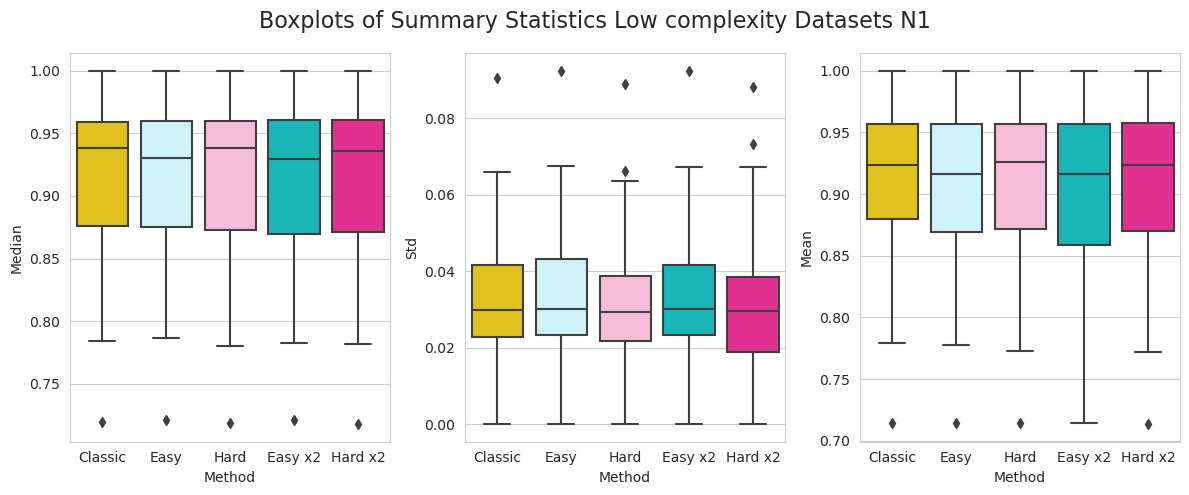

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N1
0          10           (9, 14, 12)
1          25            (9, 9, 17)
2          50           (4, 10, 21)
3         100           (6, 10, 19)
4         150           (11, 9, 15)
5         200           (10, 9, 16)
6         250           (9, 11, 15)
7         300           (6, 11, 18)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N1
0          10           (8, 13, 14)
1          25           (19, 10, 6)
2          50           (16, 9, 10)
3         100          (13, 10, 12)
4         150          (12, 11, 12)
5         200          (13, 12, 10)
6         250           (8, 12, 15)
7         300           (8, 12, 15)


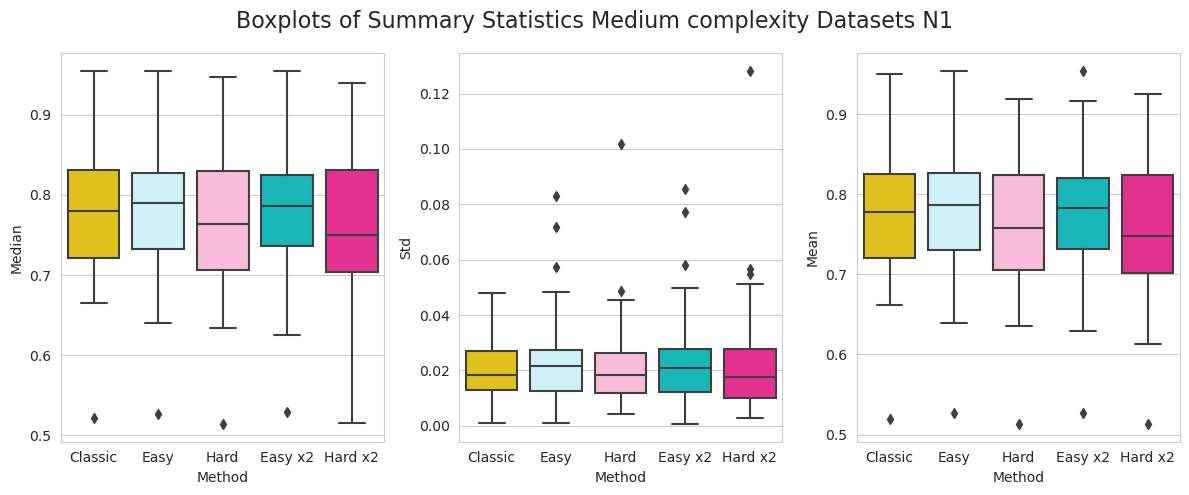

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N1
0          10          (10, 15, 19)
1          25           (16, 5, 23)
2          50           (24, 2, 18)
3         100           (24, 3, 17)
4         150           (21, 4, 19)
5         200           (24, 4, 16)
6         250           (25, 4, 15)
7         300           (23, 5, 16)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N1
0          10          (14, 12, 18)
1          25           (14, 7, 23)
2          50           (17, 4, 23)
3         100           (18, 2, 24)
4         150           (15, 2, 27)
5         200            (9, 4, 31)
6         250            (8, 5, 31)
7         300            (9, 4, 31)


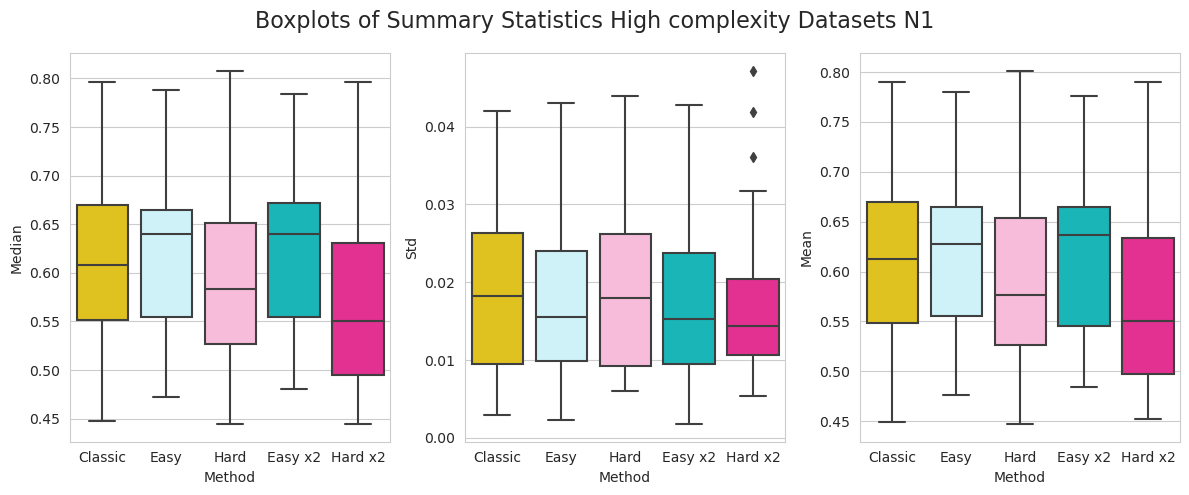

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N1
0          10           (17, 4, 12)
1          25           (16, 1, 16)
2          50            (9, 1, 23)
3         100           (21, 1, 11)
4         150           (16, 2, 15)
5         200           (16, 5, 12)
6         250           (20, 2, 11)
7         300           (19, 4, 10)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N1
0          10           (12, 1, 20)
1          25           (11, 1, 21)
2          50            (9, 1, 23)
3         100            (7, 1, 25)
4         150            (6, 3, 24)
5         200            (4, 3, 26)
6         250            (8, 2, 23)
7         300            (8, 1, 24)


In [16]:
CM = 'N1'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

**N1**

 * En los conjuntos de datos fáciles (35), está todo muy igualado, diría que lo mejor nuestro es hard. En WTL ganamos en 4 de 8, empatamos en 1 y perdemos en 3 (la primera y las 2 últimas).

 * En los conjuntos intermedios (44), lo mejor es easy y easy x2. En WTL easy gana en 6 de 8 (pierde las 2 primeras). Habría que ver cómo queda Easy x2.

 * En los datos difíciles (33), lo mejor es easy y dudo si easy o easy x2. Ambos boxplot son mejores que classic en media, mediana y std. En WTL, easy gana en 6, empata en 1 y pierde en 1 (el tercero, 50 ensamblados). Sería interesante ver si somos más estables. Desde luego damos menor std en los boxplots.

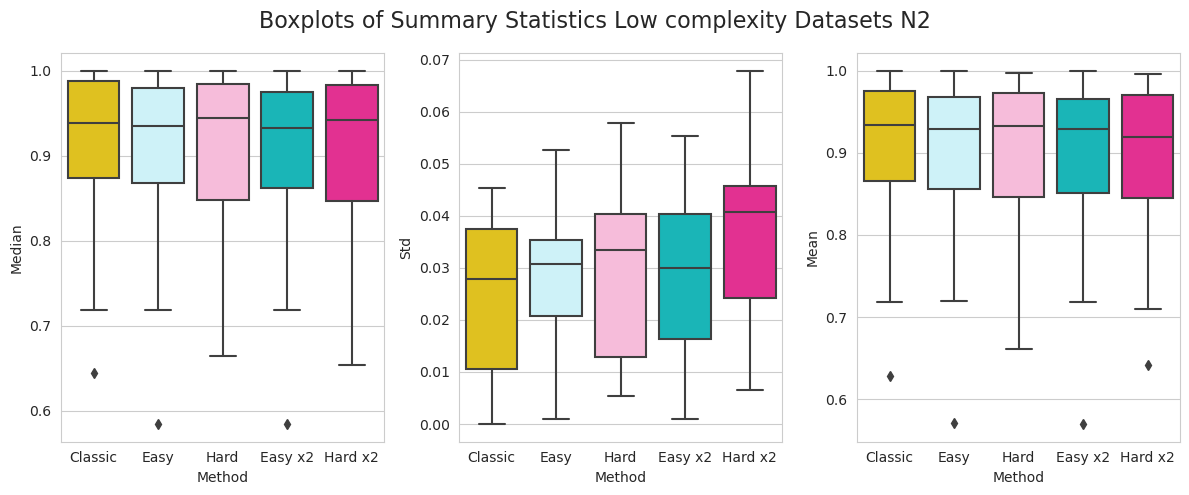

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N2
0          10             (2, 5, 4)
1          25             (2, 4, 5)
2          50             (2, 4, 5)
3         100             (1, 3, 7)
4         150             (0, 4, 7)
5         200             (1, 2, 8)
6         250             (1, 3, 7)
7         300             (2, 3, 6)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N2
0          10             (3, 5, 3)
1          25             (6, 4, 1)
2          50             (4, 3, 4)
3         100             (4, 4, 3)
4         150             (3, 5, 3)
5         200             (3, 3, 5)
6         250             (4, 3, 4)
7         300             (3, 4, 4)


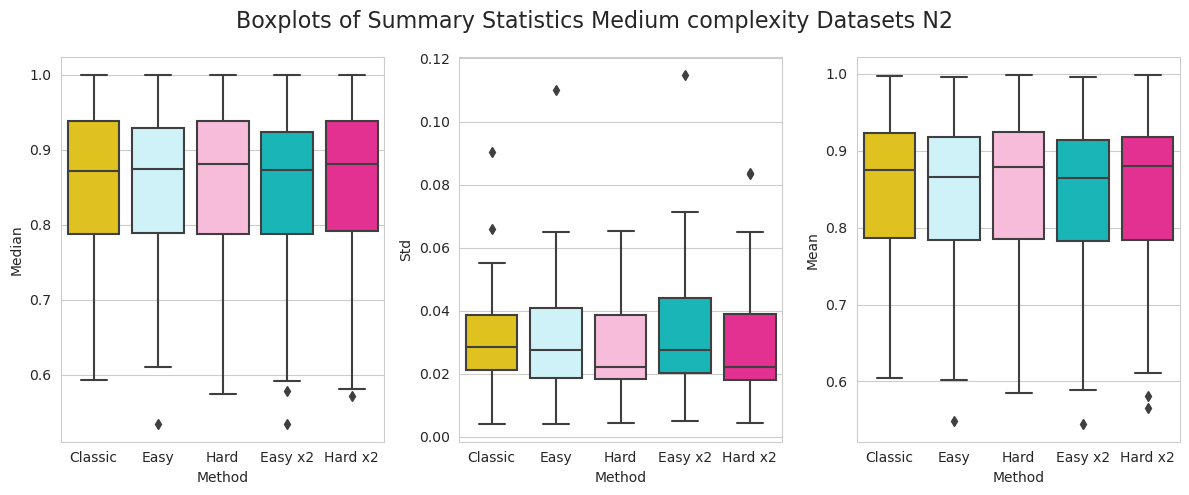

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N2
0          10            (6, 9, 11)
1          25            (6, 5, 15)
2          50            (3, 4, 19)
3         100            (5, 6, 15)
4         150            (5, 5, 16)
5         200            (7, 5, 14)
6         250            (7, 6, 13)
7         300            (6, 5, 15)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N2
0          10           (10, 6, 10)
1          25           (10, 6, 10)
2          50            (12, 6, 8)
3         100           (13, 3, 10)
4         150           (6, 10, 10)
5         200            (10, 9, 7)
6         250           (10, 6, 10)
7         300            (7, 8, 11)


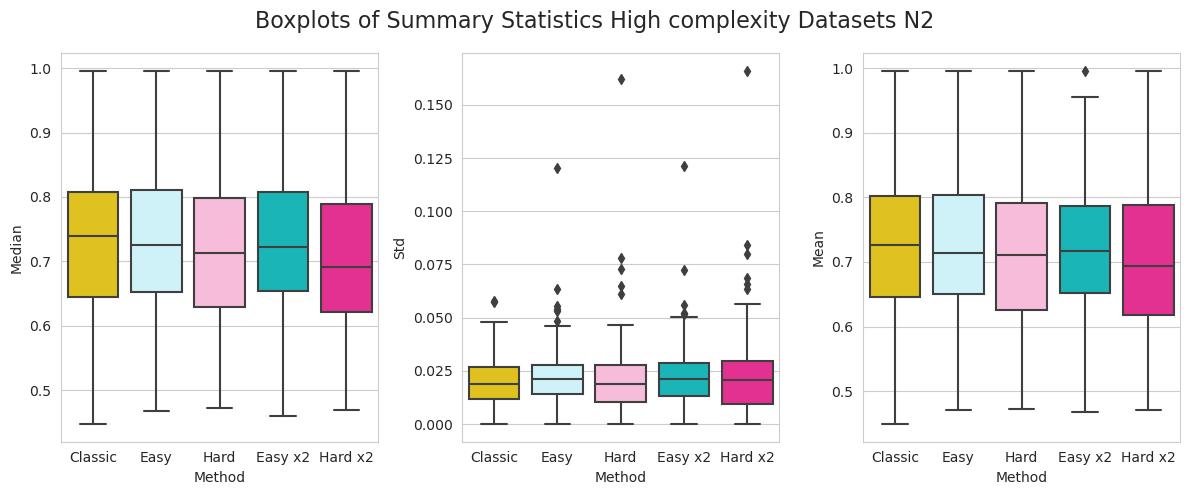

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_N2
0          10          (22, 13, 40)
1          25           (26, 8, 41)
2          50           (34, 5, 36)
3         100           (36, 6, 33)
4         150           (30, 6, 39)
5         200           (40, 4, 31)
6         250           (34, 8, 33)
7         300           (31, 8, 36)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_N2
0          10          (23, 10, 42)
1          25           (21, 7, 47)
2          50           (25, 7, 43)
3         100           (19, 4, 52)
4         150           (19, 6, 50)
5         200           (18, 6, 51)
6         250           (15, 6, 54)
7         300           (18, 4, 53)


In [17]:
CM = 'N2'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

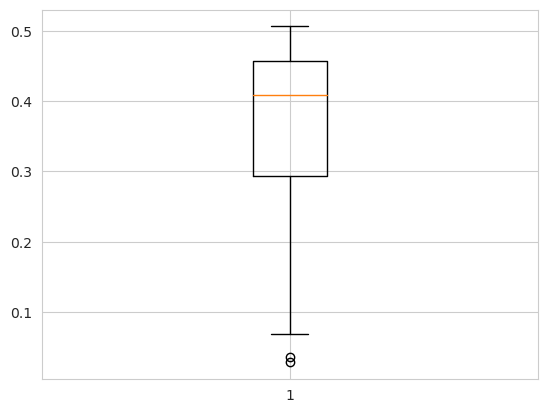

In [29]:
plt.boxplot(df_complex.N2)
plt.show()
# Rango muy concentrado entre 0.3 y 0.5

**N2**

Aquí ya vemos que la categorización de los datos se complica porque en fáciles solo hay 11.

 * En los conjuntos de datos fáciles (11),  diría que el ganador es classic GB pero vamos que es que son muy pocos datasets.

 * En los intermedios (26), parece que lo mejor para nosotros es Hard. En WTL, ganamos 3, empatamos 3 y perdemos 2. Si aquí nuestra mejor baza es Hard, lo que me indica es que esta categoría intermedia realmente es “difícil”.

 * En los difíciles (75), aquí lo mejor para nosotros es easy. En mediana es mejor easy x2 y en media parece que easy. En WTL con easy, ganamos en 3 y perdemos en 5, o sea que es mejor Classic, aunque habría que mirar mejor easy x2 y la categorización.

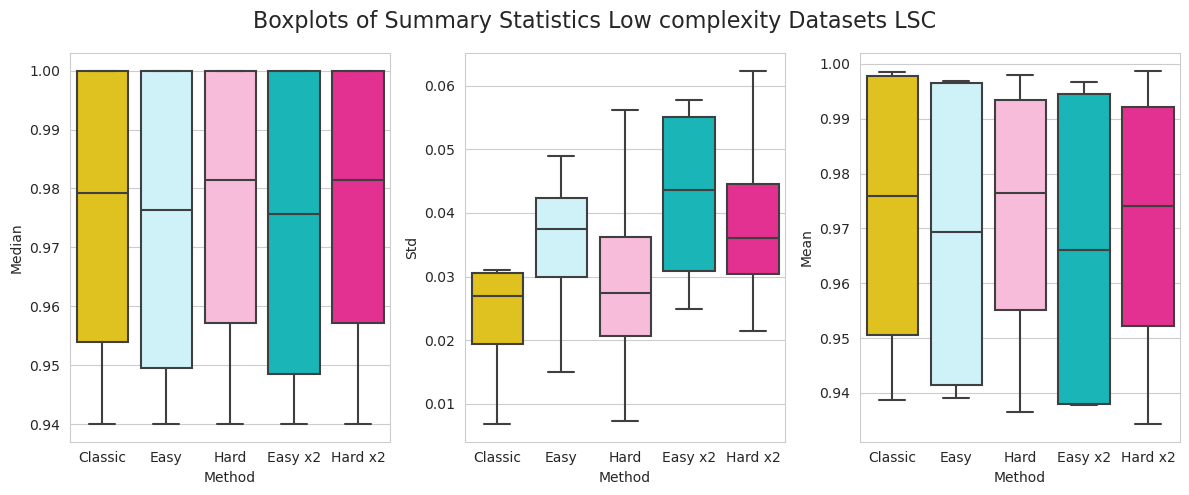

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_LSC
0          10              (0, 3, 1)
1          25              (0, 3, 1)
2          50              (0, 3, 1)
3         100              (0, 3, 1)
4         150              (0, 3, 1)
5         200              (0, 3, 1)
6         250              (0, 3, 1)
7         300              (0, 3, 1)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_LSC
0          10              (1, 3, 0)
1          25              (1, 3, 0)
2          50              (1, 3, 0)
3         100              (1, 3, 0)
4         150              (1, 3, 0)
5         200              (1, 3, 0)
6         250              (1, 3, 0)
7         300              (1, 3, 0)


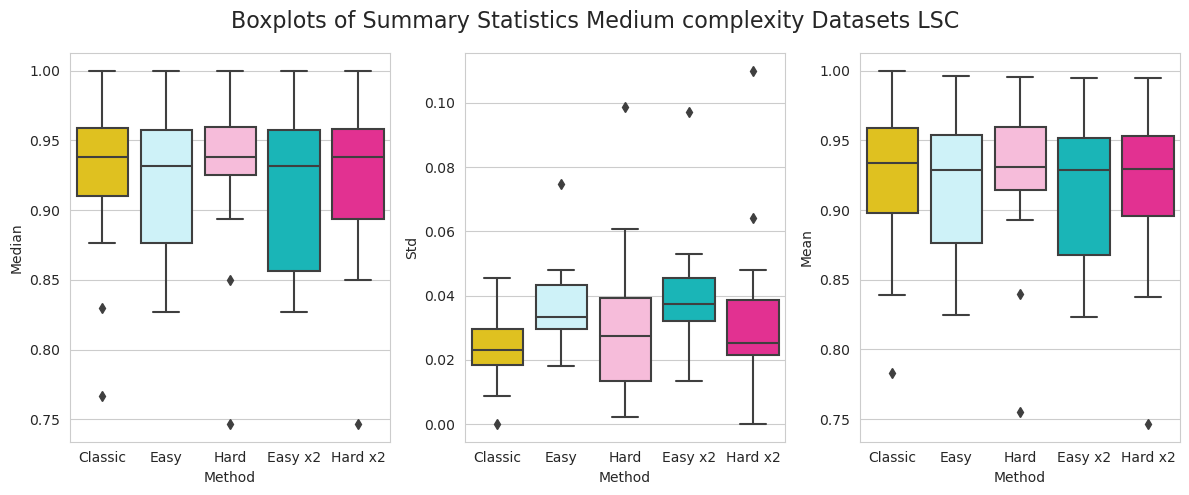

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_LSC
0          10              (3, 6, 4)
1          25              (1, 7, 5)
2          50              (4, 4, 5)
3         100              (2, 5, 6)
4         150              (2, 4, 7)
5         200              (3, 6, 4)
6         250              (4, 6, 3)
7         300              (5, 5, 3)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_LSC
0          10              (2, 4, 7)
1          25              (6, 5, 2)
2          50              (3, 7, 3)
3         100              (4, 3, 6)
4         150              (4, 5, 4)
5         200              (4, 4, 5)
6         250              (5, 5, 3)
7         300              (2, 6, 5)


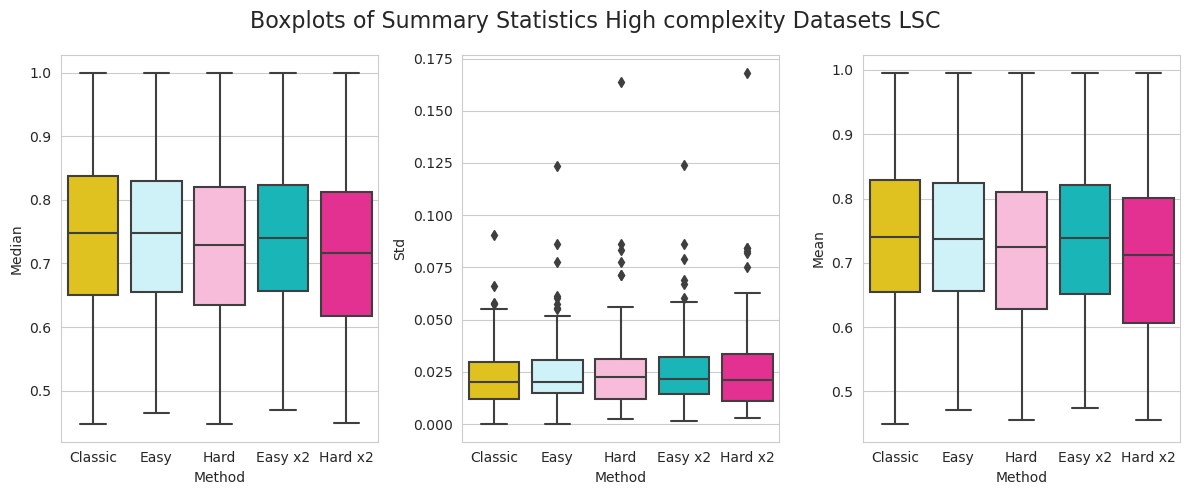

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_LSC
0          10           (36, 17, 42)
1          25           (37, 10, 48)
2          50            (37, 5, 53)
3         100            (39, 5, 51)
4         150            (37, 8, 50)
5         200            (40, 6, 49)
6         250           (39, 11, 45)
7         300            (41, 7, 47)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_LSC
0          10           (29, 19, 47)
1          25            (28, 5, 62)
2          50            (28, 5, 62)
3         100            (28, 6, 61)
4         150            (27, 7, 61)
5         200            (25, 9, 61)
6         250            (25, 8, 62)
7         300            (19, 9, 67)


In [18]:
CM = 'LSC'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

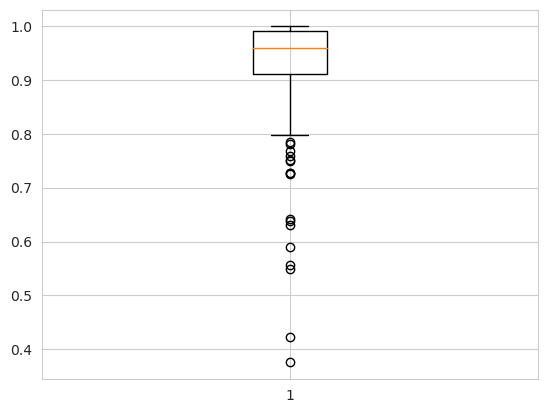

In [25]:
plt.boxplot(df_complex.LSC)
plt.show()

**LSC**

La categorización cada vez peor: low (4), intermediate (13), high (95).

No lo analizamos porque realmente la categorización no hace nada. Gana classic en los difíciles (que es como ganar en todo realmente). En estas medidas de complejidad difíciles de interpretar, no sé cómo realizar la categorización porque realmente todos los valores están en torno al 0.9.

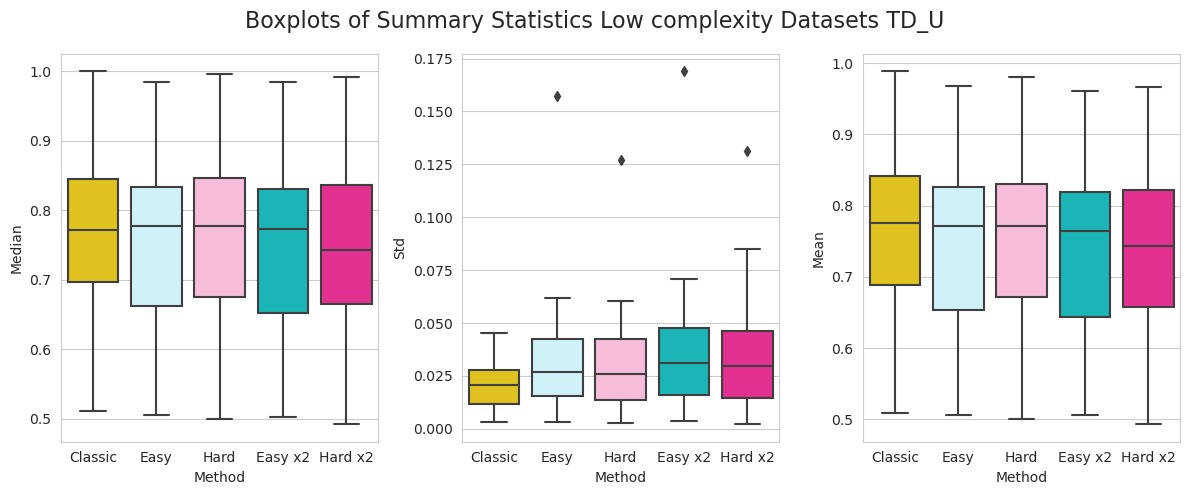

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_TD_U
0          10              (9, 9, 20)
1          25              (9, 1, 28)
2          50              (9, 3, 26)
3         100             (10, 2, 26)
4         150             (11, 0, 27)
5         200             (11, 2, 25)
6         250             (13, 1, 24)
7         300             (12, 2, 24)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_TD_U
0          10             (12, 5, 21)
1          25             (12, 0, 26)
2          50              (9, 1, 28)
3         100              (9, 4, 25)
4         150              (6, 3, 29)
5         200             (10, 2, 26)
6         250             (11, 5, 22)
7         300             (11, 3, 24)


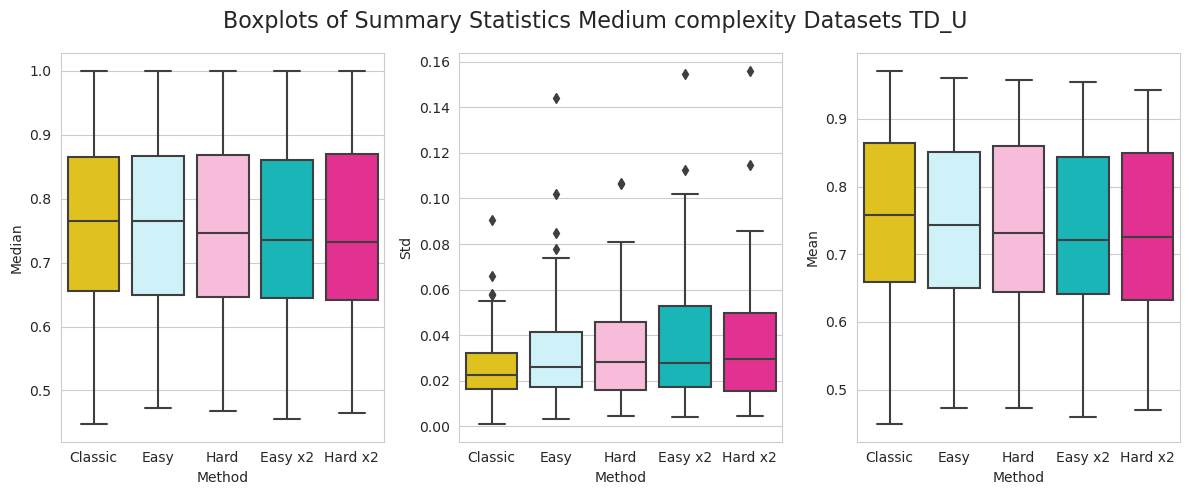

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_TD_U
0          10            (12, 15, 40)
1          25             (16, 6, 45)
2          50             (21, 4, 42)
3         100             (19, 6, 42)
4         150             (16, 8, 43)
5         200             (21, 7, 39)
6         250             (18, 8, 41)
7         300             (20, 8, 39)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_TD_U
0          10             (22, 4, 41)
1          25             (15, 6, 46)
2          50             (20, 6, 41)
3         100             (25, 4, 38)
4         150             (23, 6, 38)
5         200             (18, 8, 41)
6         250            (20, 10, 37)
7         300            (18, 13, 36)


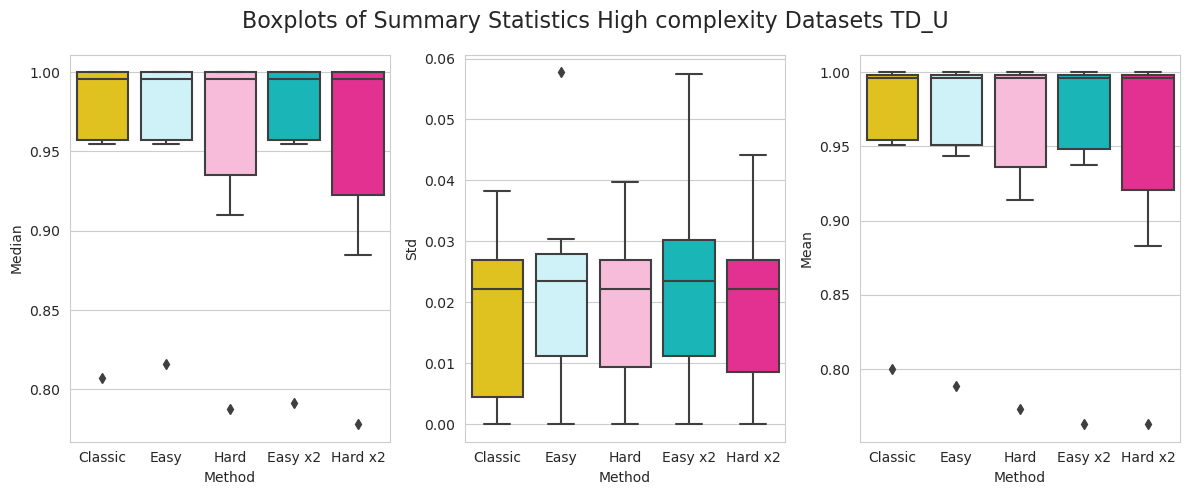

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_TD_U
0          10               (0, 6, 1)
1          25               (0, 5, 2)
2          50               (0, 5, 2)
3         100               (0, 6, 1)
4         150               (1, 6, 0)
5         200               (0, 6, 1)
6         250               (0, 6, 1)
7         300               (0, 7, 0)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_TD_U
0          10               (0, 5, 2)
1          25               (0, 5, 2)
2          50               (0, 5, 2)
3         100               (0, 5, 2)
4         150               (0, 5, 2)
5         200               (0, 5, 2)
6         250               (0, 5, 2)
7         300               (0, 5, 2)


In [22]:
CM = 'TD_U'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

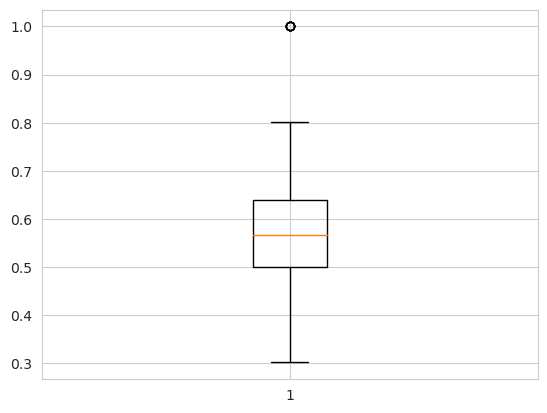

In [26]:
plt.boxplot(df_complex.TD_U)
plt.show()
# Su rango está muy concentrado en valores intermedios

**TDU**

La categorización tampoco está bien porque hay muy pocos difíciles y muchos intermedios.

 * Datos fáciles (38), lo mejor es hard, pero claramente gana classic.

 * Datos intermedios (67), lo veo muy igualado entre hard y easy. Claramente gana Classic.

 * Datos difíciles (7).

Aquí tiene sentido que gane classic con mayor claridad dado que TDU se basa en árboles, entonces la información de complejidad que pueda añadir al GB no es novedosa dado que se basan en el mismo algoritmo.

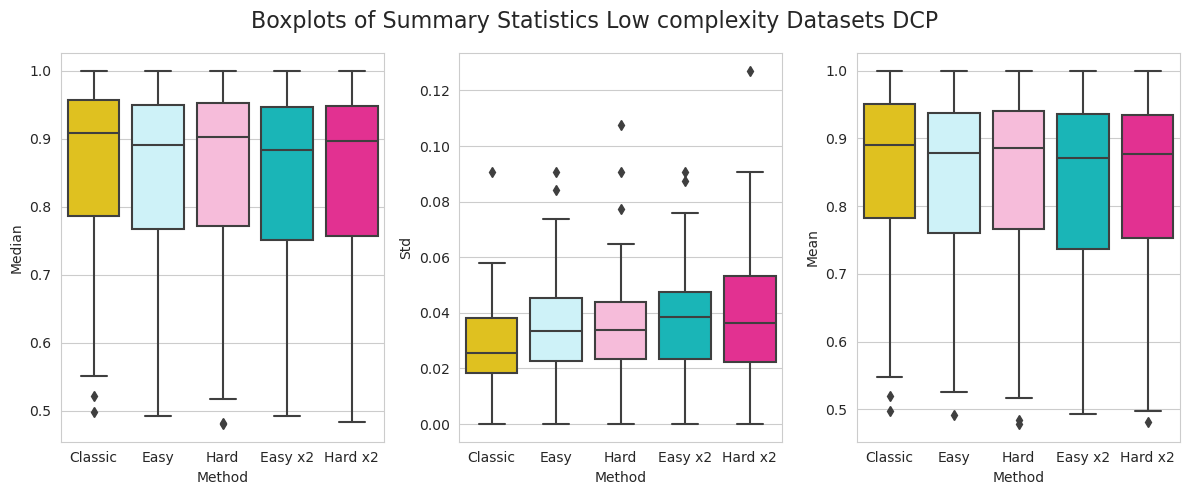

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_DCP
0          10            (6, 11, 31)
1          25            (6, 13, 29)
2          50            (5, 14, 29)
3         100            (8, 12, 28)
4         150            (9, 12, 27)
5         200           (10, 13, 25)
6         250           (10, 14, 24)
7         300            (9, 14, 25)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_DCP
0          10            (9, 10, 29)
1          25            (9, 12, 27)
2          50            (6, 13, 29)
3         100           (11, 13, 24)
4         150            (5, 18, 25)
5         200            (7, 19, 22)
6         250            (6, 17, 25)
7         300            (6, 16, 26)


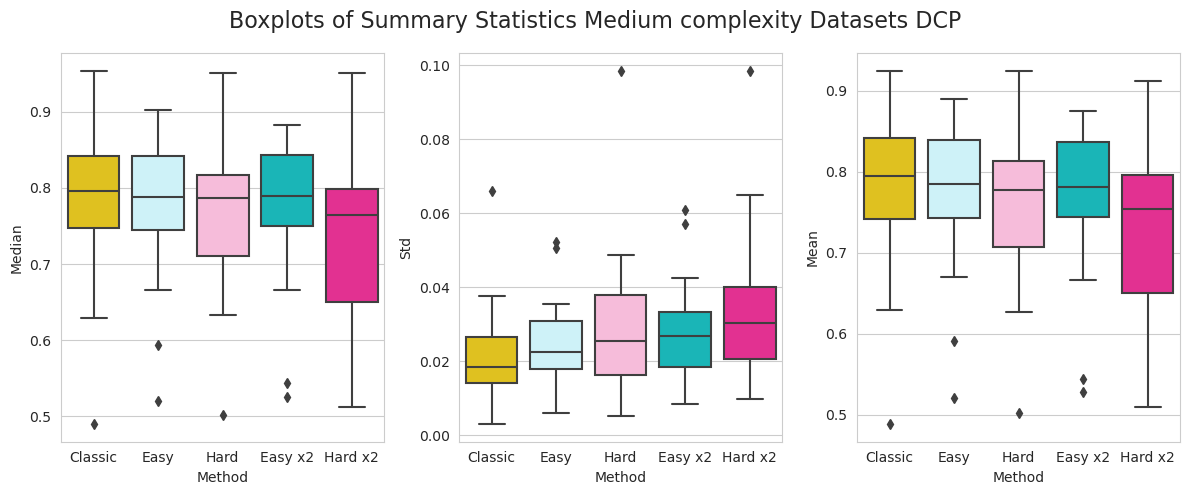

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_DCP
0          10             (3, 8, 17)
1          25             (7, 3, 18)
2          50             (7, 2, 19)
3         100             (8, 0, 20)
4         150             (7, 2, 19)
5         200             (8, 1, 19)
6         250            (11, 1, 16)
7         300            (12, 1, 15)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_DCP
0          10             (8, 0, 20)
1          25             (7, 0, 21)
2          50             (9, 1, 18)
3         100             (4, 2, 22)
4         150             (5, 0, 23)
5         200             (7, 1, 20)
6         250             (6, 1, 21)
7         300             (7, 0, 21)


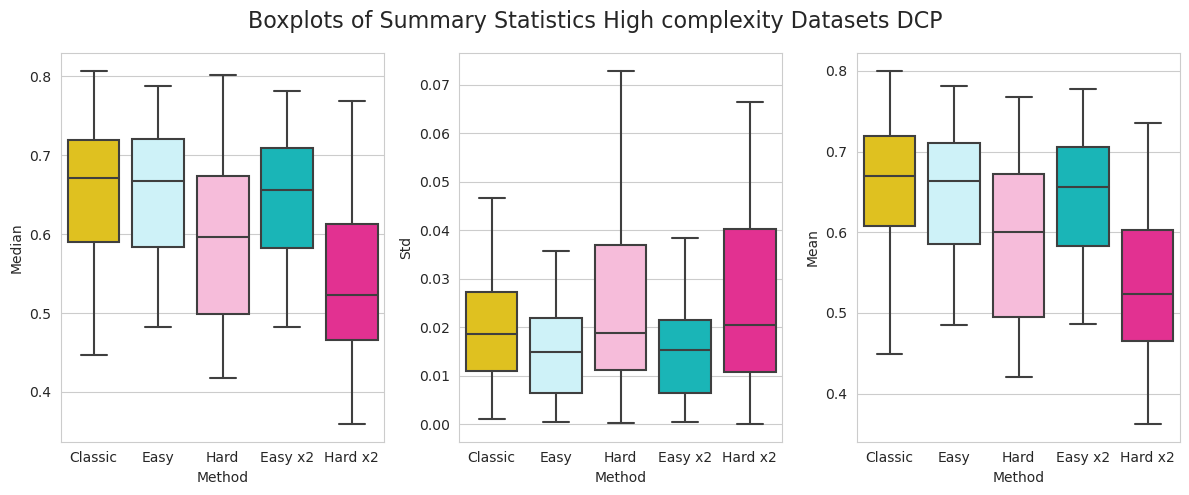

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_DCP
0          10            (12, 7, 17)
1          25             (8, 5, 23)
2          50            (11, 1, 24)
3         100            (11, 2, 23)
4         150            (10, 0, 26)
5         200            (12, 2, 22)
6         250            (11, 2, 23)
7         300            (14, 2, 20)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_DCP
0          10             (8, 2, 26)
1          25             (3, 0, 33)
2          50             (4, 0, 32)
3         100             (2, 2, 32)
4         150             (3, 1, 32)
5         200             (2, 2, 32)
6         250             (3, 2, 31)
7         300             (5, 0, 31)


In [19]:
CM = 'DCP'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

**DCP**

 * Datos fáciles (48), lo mejor nuestro es hard, pero gana claramente classic GB.

 * Datos intermedios (28), lo mejor es easy y diría que easy x2. En WTL claramente perdemos, o sea que habría que ver cómo quedaría el easy x2.

 * Datos difíciles (36), lo mejor es easy (diría que solo easy y no easy x2) pero muy igualado con classic GB. En WTL, claramente gana classic GB.

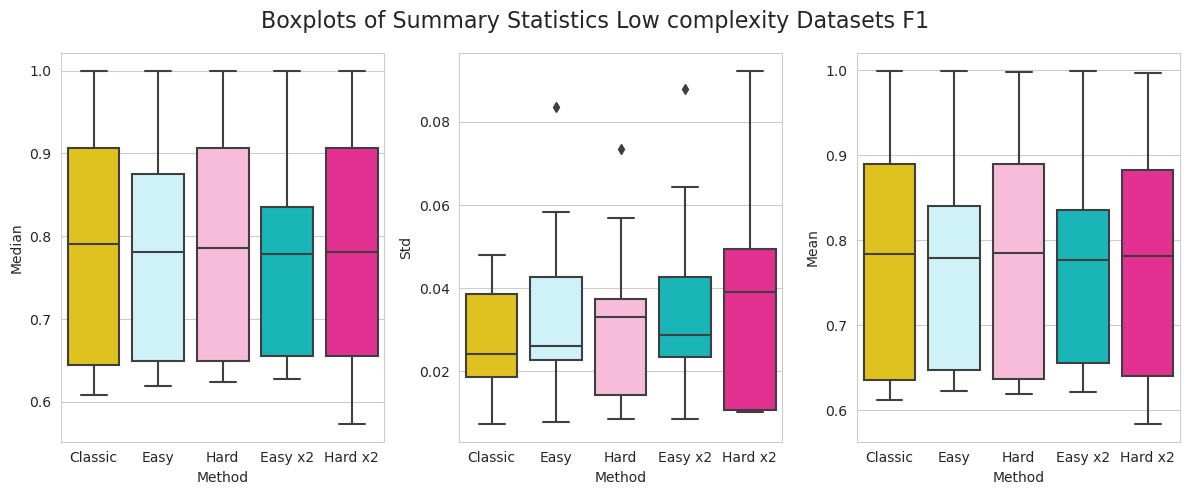

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_F1
0          10             (1, 9, 3)
1          25             (4, 4, 5)
2          50             (5, 4, 4)
3         100             (3, 5, 5)
4         150             (3, 4, 6)
5         200             (4, 2, 7)
6         250             (3, 3, 7)
7         300             (2, 4, 7)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_F1
0          10             (3, 7, 3)
1          25             (4, 6, 3)
2          50             (7, 3, 3)
3         100             (5, 3, 5)
4         150             (5, 3, 5)
5         200             (4, 5, 4)
6         250             (4, 4, 5)
7         300             (4, 3, 6)


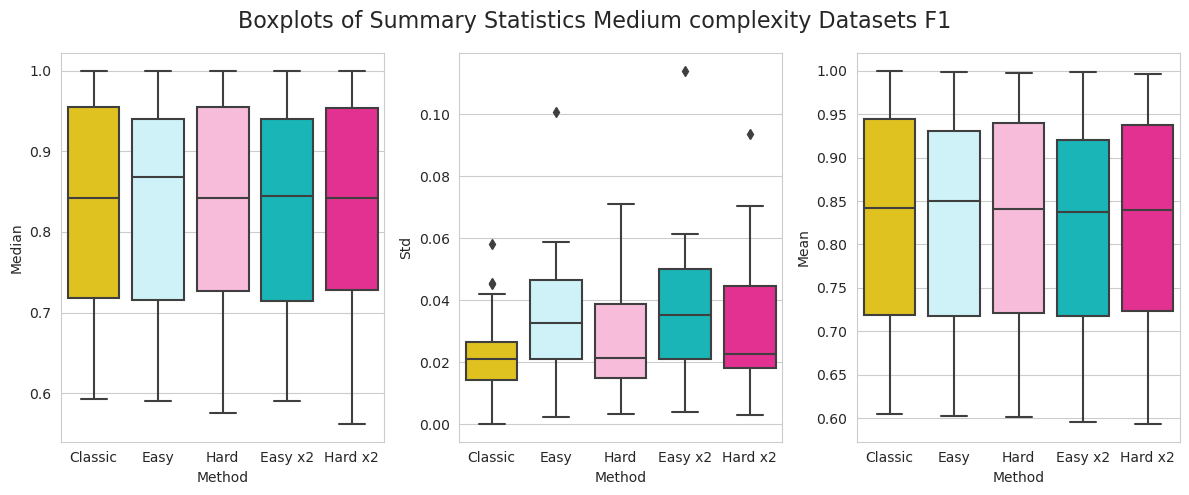

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_F1
0          10           (7, 10, 12)
1          25           (11, 6, 12)
2          50            (9, 6, 14)
3         100           (11, 6, 12)
4         150           (10, 9, 10)
5         200           (10, 8, 11)
6         250            (8, 6, 15)
7         300            (8, 8, 13)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_F1
0          10            (8, 13, 8)
1          25           (11, 11, 7)
2          50            (9, 9, 11)
3         100           (10, 7, 12)
4         150            (8, 9, 12)
5         200           (8, 10, 11)
6         250           (7, 10, 12)
7         300           (10, 11, 8)


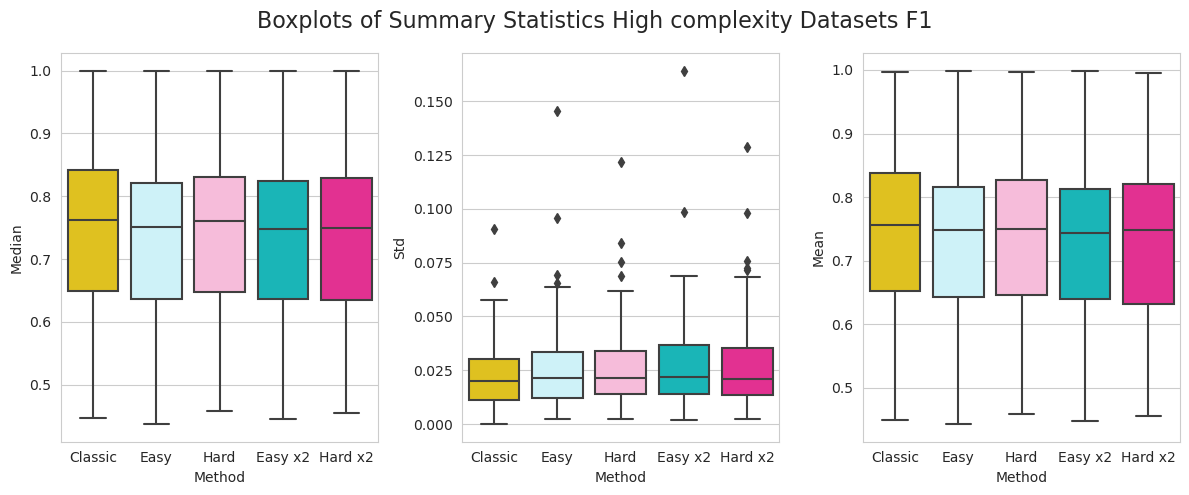

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_F1
0          10          (23, 14, 33)
1          25           (26, 5, 39)
2          50           (28, 5, 37)
3         100           (24, 4, 42)
4         150           (18, 5, 47)
5         200           (19, 6, 45)
6         250           (19, 7, 44)
7         300           (21, 6, 43)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_F1
0          10          (21, 11, 38)
1          25           (25, 7, 38)
2          50           (28, 6, 36)
3         100           (33, 4, 33)
4         150           (32, 5, 33)
5         200           (31, 8, 31)
6         250          (25, 11, 34)
7         300           (29, 6, 35)


In [21]:
CM = 'F1'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

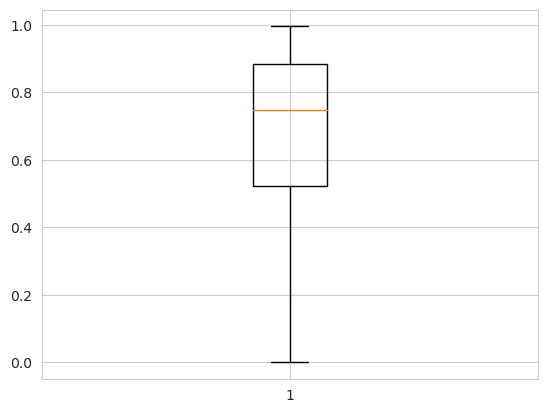

In [27]:
plt.boxplot(df_complex.F1)
plt.show()
# Mucha densidad de valores a partir del 0.6.

**F1**

La categorización no funciona: low (13), intermediate (29), high (70)

 * En fácil no analizo por la escasez.

 * Datos intermedios (13), lo mejor nuestro es hard. En el WTL, ganamos en 2, empatamos en 1 y perdemos en 5. Son muy pocos datos.

 * Datos difíciles (70), lo mejor nuestro es hard. ¡Ojo! Es la primera vez que en datos difíciles para nosotros es mejor hard que easy. Pero bueno, aquí están metidos todos los datos. En WTL con hard logramos un par de empates y en el resto perdemos. Claramente le ganador es Classic GB.

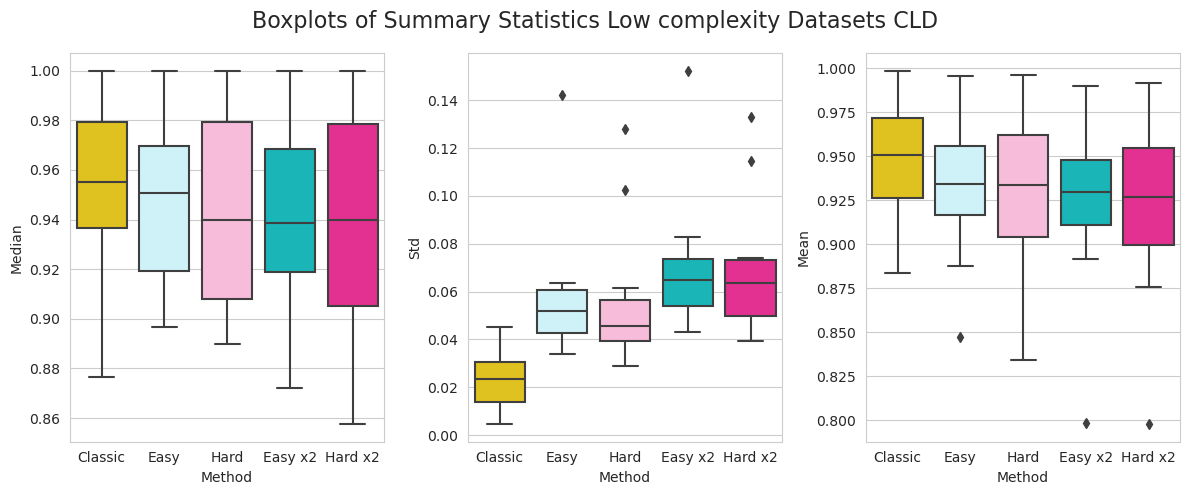

Low complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_CLD
0          10              (2, 3, 6)
1          25              (3, 4, 4)
2          50              (1, 5, 5)
3         100              (1, 4, 6)
4         150              (1, 4, 6)
5         200              (1, 5, 5)
6         250              (2, 4, 5)
7         300              (2, 5, 4)
Low complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_CLD
0          10              (3, 3, 5)
1          25              (2, 4, 5)
2          50              (4, 4, 3)
3         100              (3, 4, 4)
4         150              (2, 4, 5)
5         200              (3, 4, 4)
6         250              (2, 4, 5)
7         300              (1, 5, 5)


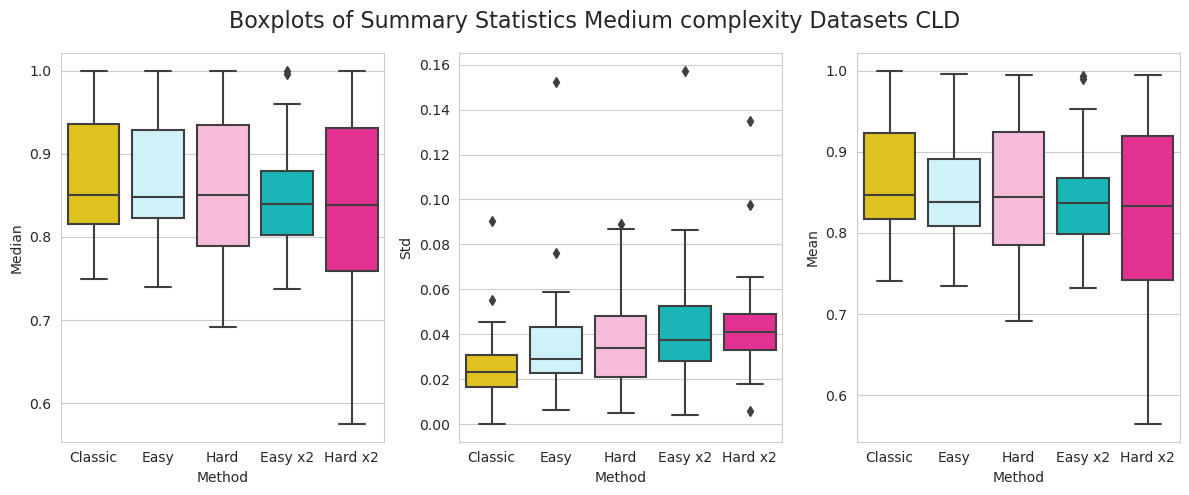

Medium complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_CLD
0          10            (4, 13, 16)
1          25            (4, 10, 19)
2          50             (9, 6, 18)
3         100             (9, 7, 17)
4         150            (10, 6, 17)
5         200             (9, 6, 18)
6         250             (5, 8, 20)
7         300             (8, 9, 16)
Medium complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_CLD
0          10             (9, 6, 18)
1          25             (9, 4, 20)
2          50             (6, 5, 22)
3         100             (4, 6, 23)
4         150             (6, 6, 21)
5         200             (5, 8, 20)
6         250             (4, 9, 20)
7         300             (4, 9, 20)


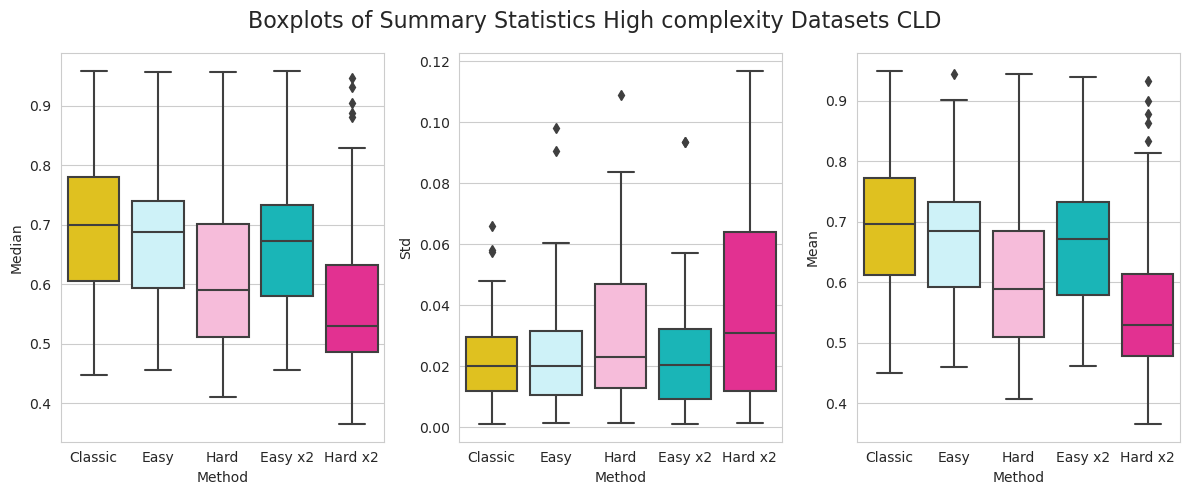

High complexity datasets: WTL Classic vs sw_easy
   n_ensemble sample_weight_easy_CLD
0          10           (16, 11, 41)
1          25            (16, 1, 51)
2          50            (19, 1, 48)
3         100            (25, 1, 42)
4         150            (18, 6, 44)
5         200            (19, 4, 45)
6         250            (20, 4, 44)
7         300            (21, 2, 45)
High complexity datasets: WTL Classic vs sw_hard
   n_ensemble sample_weight_hard_CLD
0          10             (8, 2, 58)
1          25             (8, 1, 59)
2          50             (8, 1, 59)
3         100             (7, 0, 61)
4         150             (7, 3, 58)
5         200             (9, 2, 57)
6         250            (10, 3, 55)
7         300             (9, 3, 56)


In [20]:
CM = 'CLD'
loss_function = 'exponential'
summary_pivot_low, summary_pivot_medium, summary_pivot_high, wtl_sw_easy_low, wtl_sw_easy_medium,wtl_sw_easy_high,wtl_sw_hard_low, wtl_sw_hard_medium, wtl_sw_hard_high = summary_CM_complexity_dataset(CM,all_datasets,df_complex, loss_function)

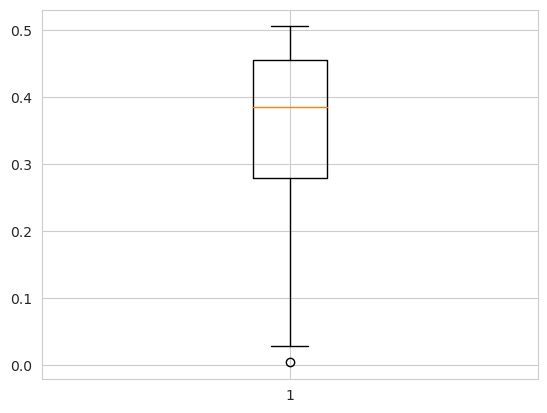

In [28]:
plt.boxplot(df_complex.CLD)
plt.show()
# Mucha densidad concentrada entre 0.3 y 0.5

**CLD**

La categorización no funciona: low (11), intermediate (33), high (68)

 * Los fáciles no los analizo por falta de datos.

 * Datos intermedios, lo mejor para nosotros sería hard pero claramente gana classic GB.

 * Datos difíciles, lo mejor para nosotros es easy pero claramente gana classic GB.

In [88]:
win_tie_loss_df, all_results = win_tie_loss_comparison_info_complexity(all_datasets, df_complex, loss_function='exponential', main_method='classic', compare_method='sample_weight_easy')

In [89]:
results_df = pd.DataFrame(all_results)
results_df

,n_ensemble,compl_measure,result,complexity_value,dataset_name,classic,sample_weight_easy
0,10,Hostility,loss,0.229730,analcatdata_gviolence,0.971429,0.914286
1,10,Hostility,loss,0.181481,heart-statlog,0.818519,0.785185
2,10,Hostility,loss,0.337098,diabetic_retinopathy,0.645525,0.597759
3,10,Hostility,loss,0.214286,hutsof99_logis,0.728571,0.671429
4,10,Hostility,win,0.342900,disclosure_x_bias,0.522614,0.531660
...,...,...,...,...,...,...,...
8059,300,F1,tie,0.828231,bodyfat,0.996000,0.996000
8060,300,F1,loss,0.889940,vehicle2,0.972801,0.971653
8061,300,F1,win,0.986908,disclosure_x_tampered,0.500158,0.513749
8062,300,F1,loss,0.744147,boston,0.881255,0.873451


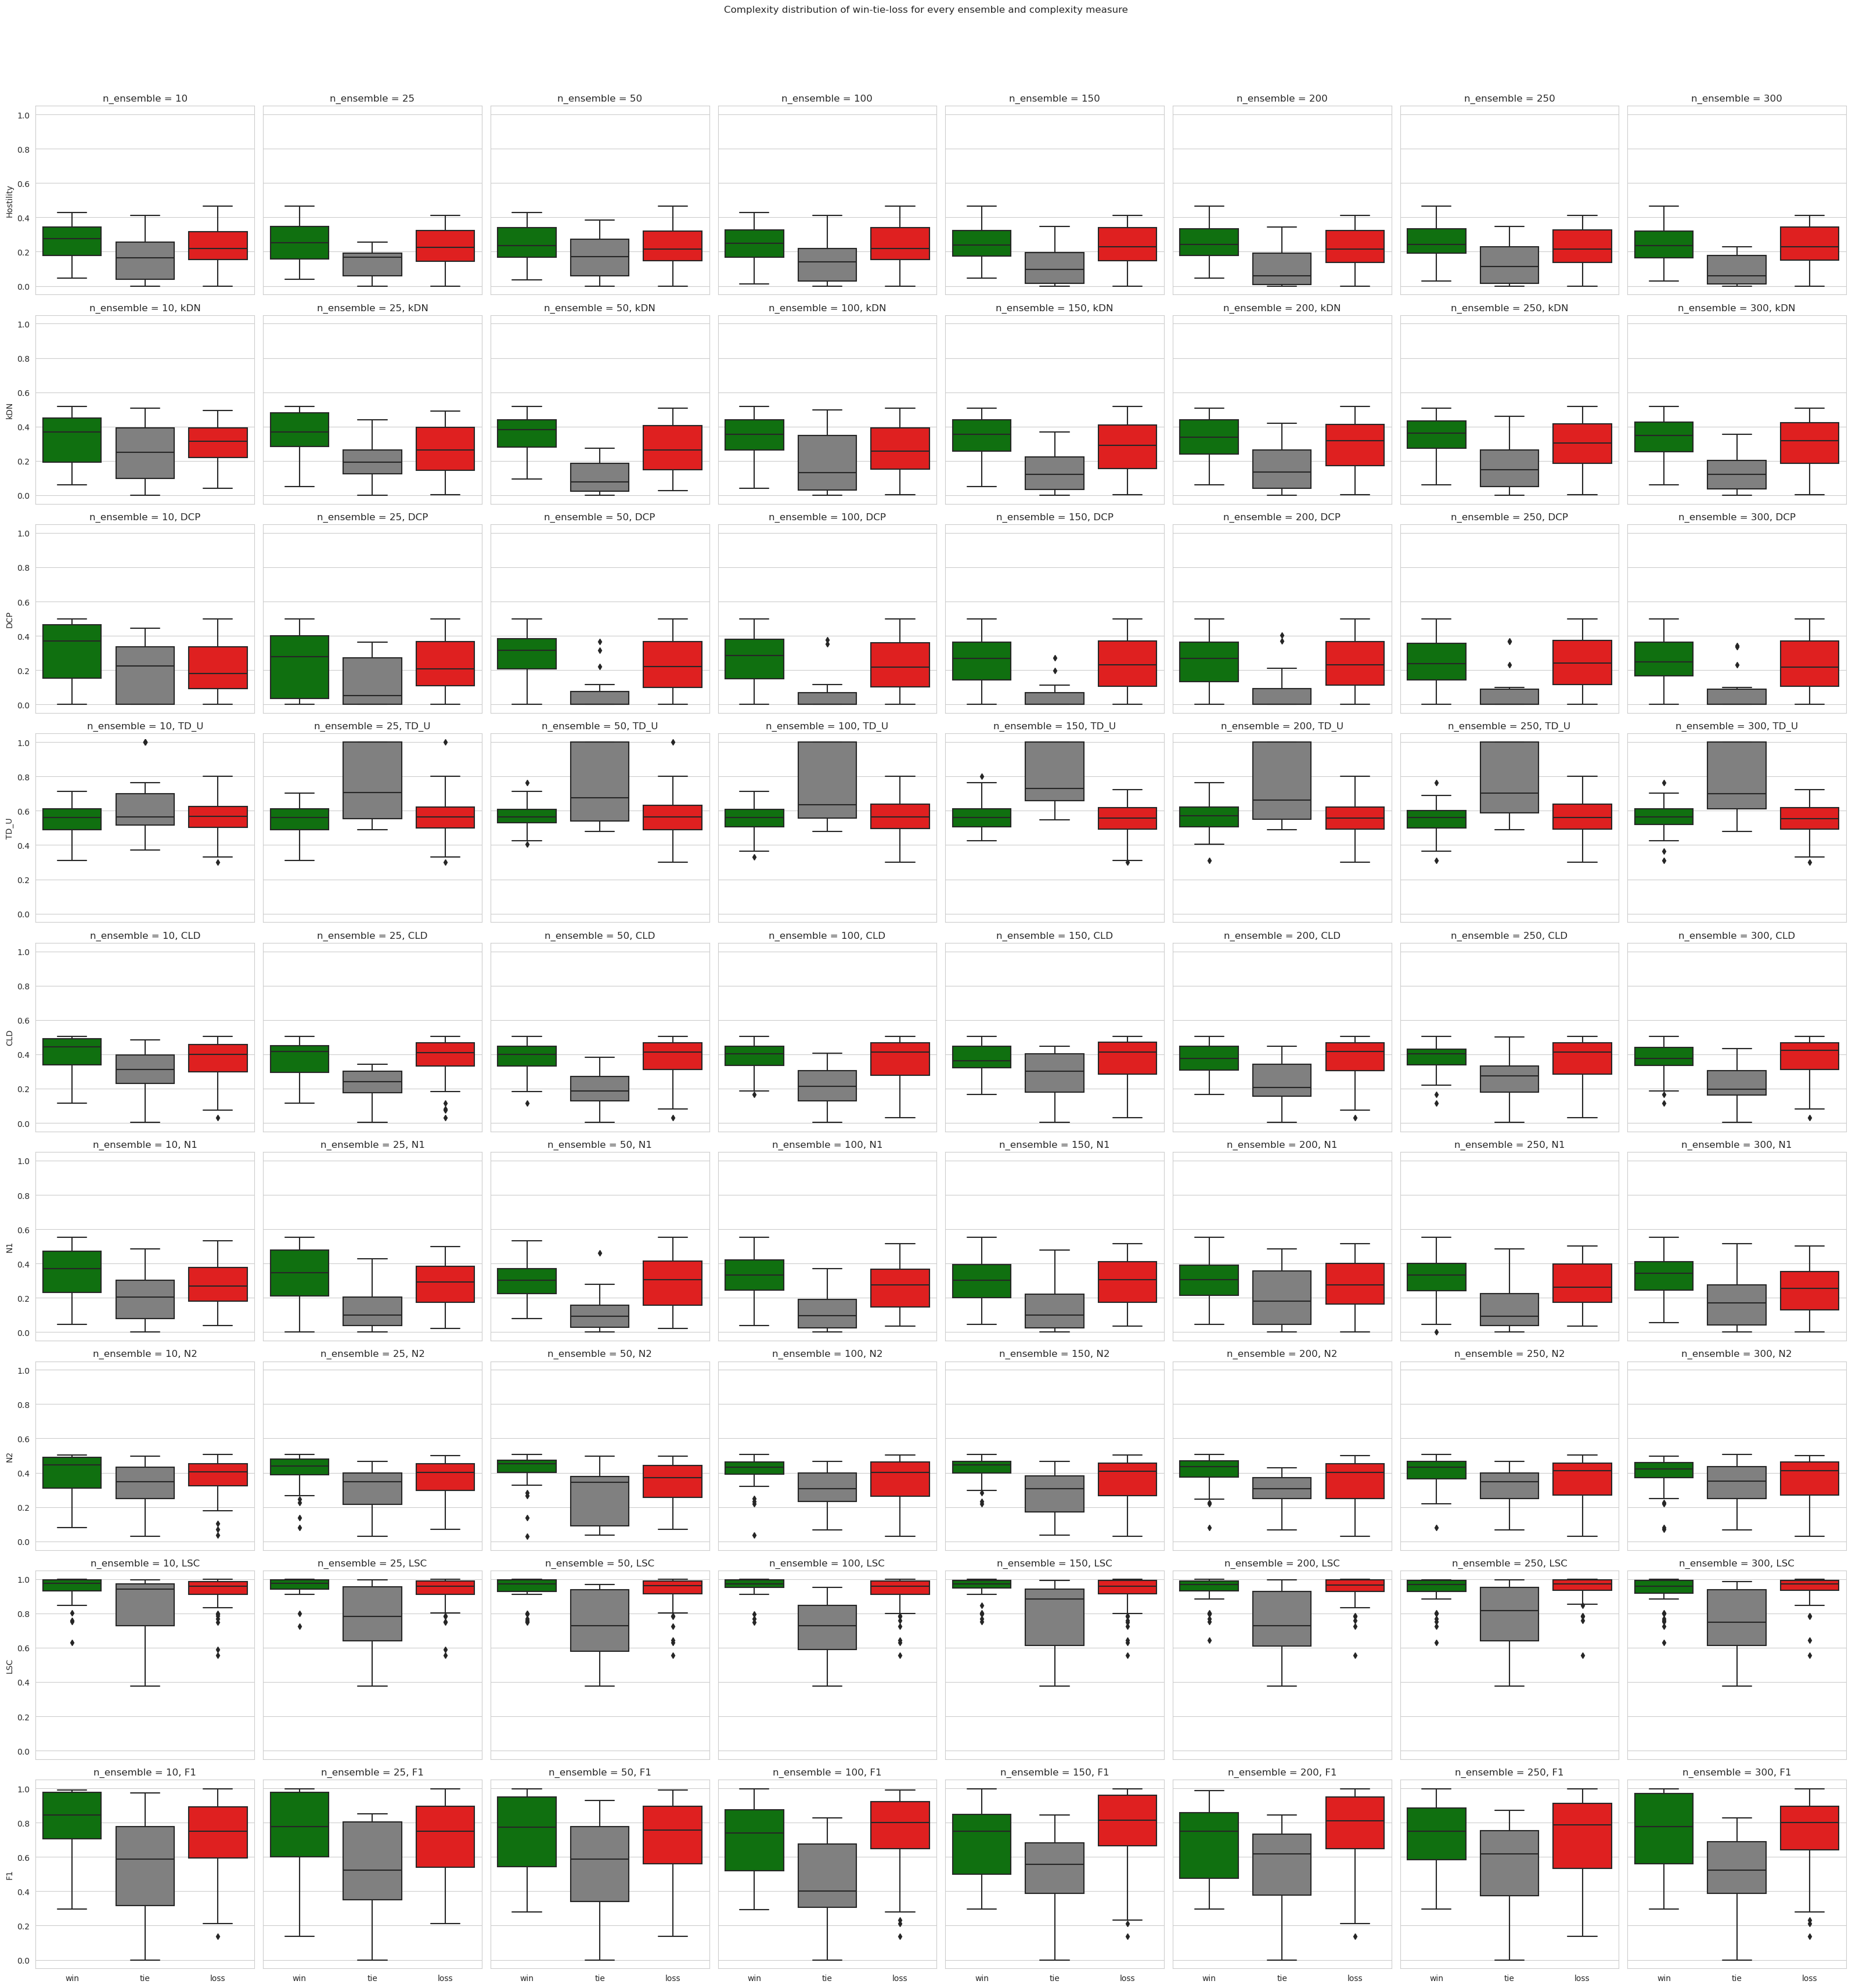

In [91]:
list_CM = ['Hostility','kDN','DCP','TD_U','CLD','N1','N2','LSC','F1']
n_ensemble_values = [10, 25, 50, 100, 150, 200, 250, 300]
# Crear la cuadrícula de gráficos
n_rows = len(list_CM)
n_cols = len(n_ensemble_values)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey=True,sharex=True)
fig.suptitle("Complexity distribution of win-tie-loss for every ensemble and complexity measure")

paleta = {'win': 'green', 'tie': 'grey', 'loss': 'red'}
orden = ['win', 'tie', 'loss']  # Orden fijo de categorías

for i, compl_measure in enumerate(list_CM):
    for j, n in enumerate(n_ensemble_values):
            # Filtrar los datos para la medida de complejidad y n_ensemble específicos
        subset = results_df[(results_df['n_ensemble'] == n) & (results_df['compl_measure'] == compl_measure)]

        # Crear el boxplot
        sns.boxplot(data=subset, x='result', y='complexity_value', ax=axes[i, j], palette=paleta, order=orden)
        axes[i, j].set_title(f'n_ensemble = {n}, {compl_measure}')
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Ajustar etiquetas generales
for ax, compl_measure in zip(axes[:, 0], list_CM):
    ax.set_ylabel(compl_measure)

for ax, n in zip(axes[0, :], n_ensemble_values):
    ax.set_title(f'n_ensemble = {n}')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


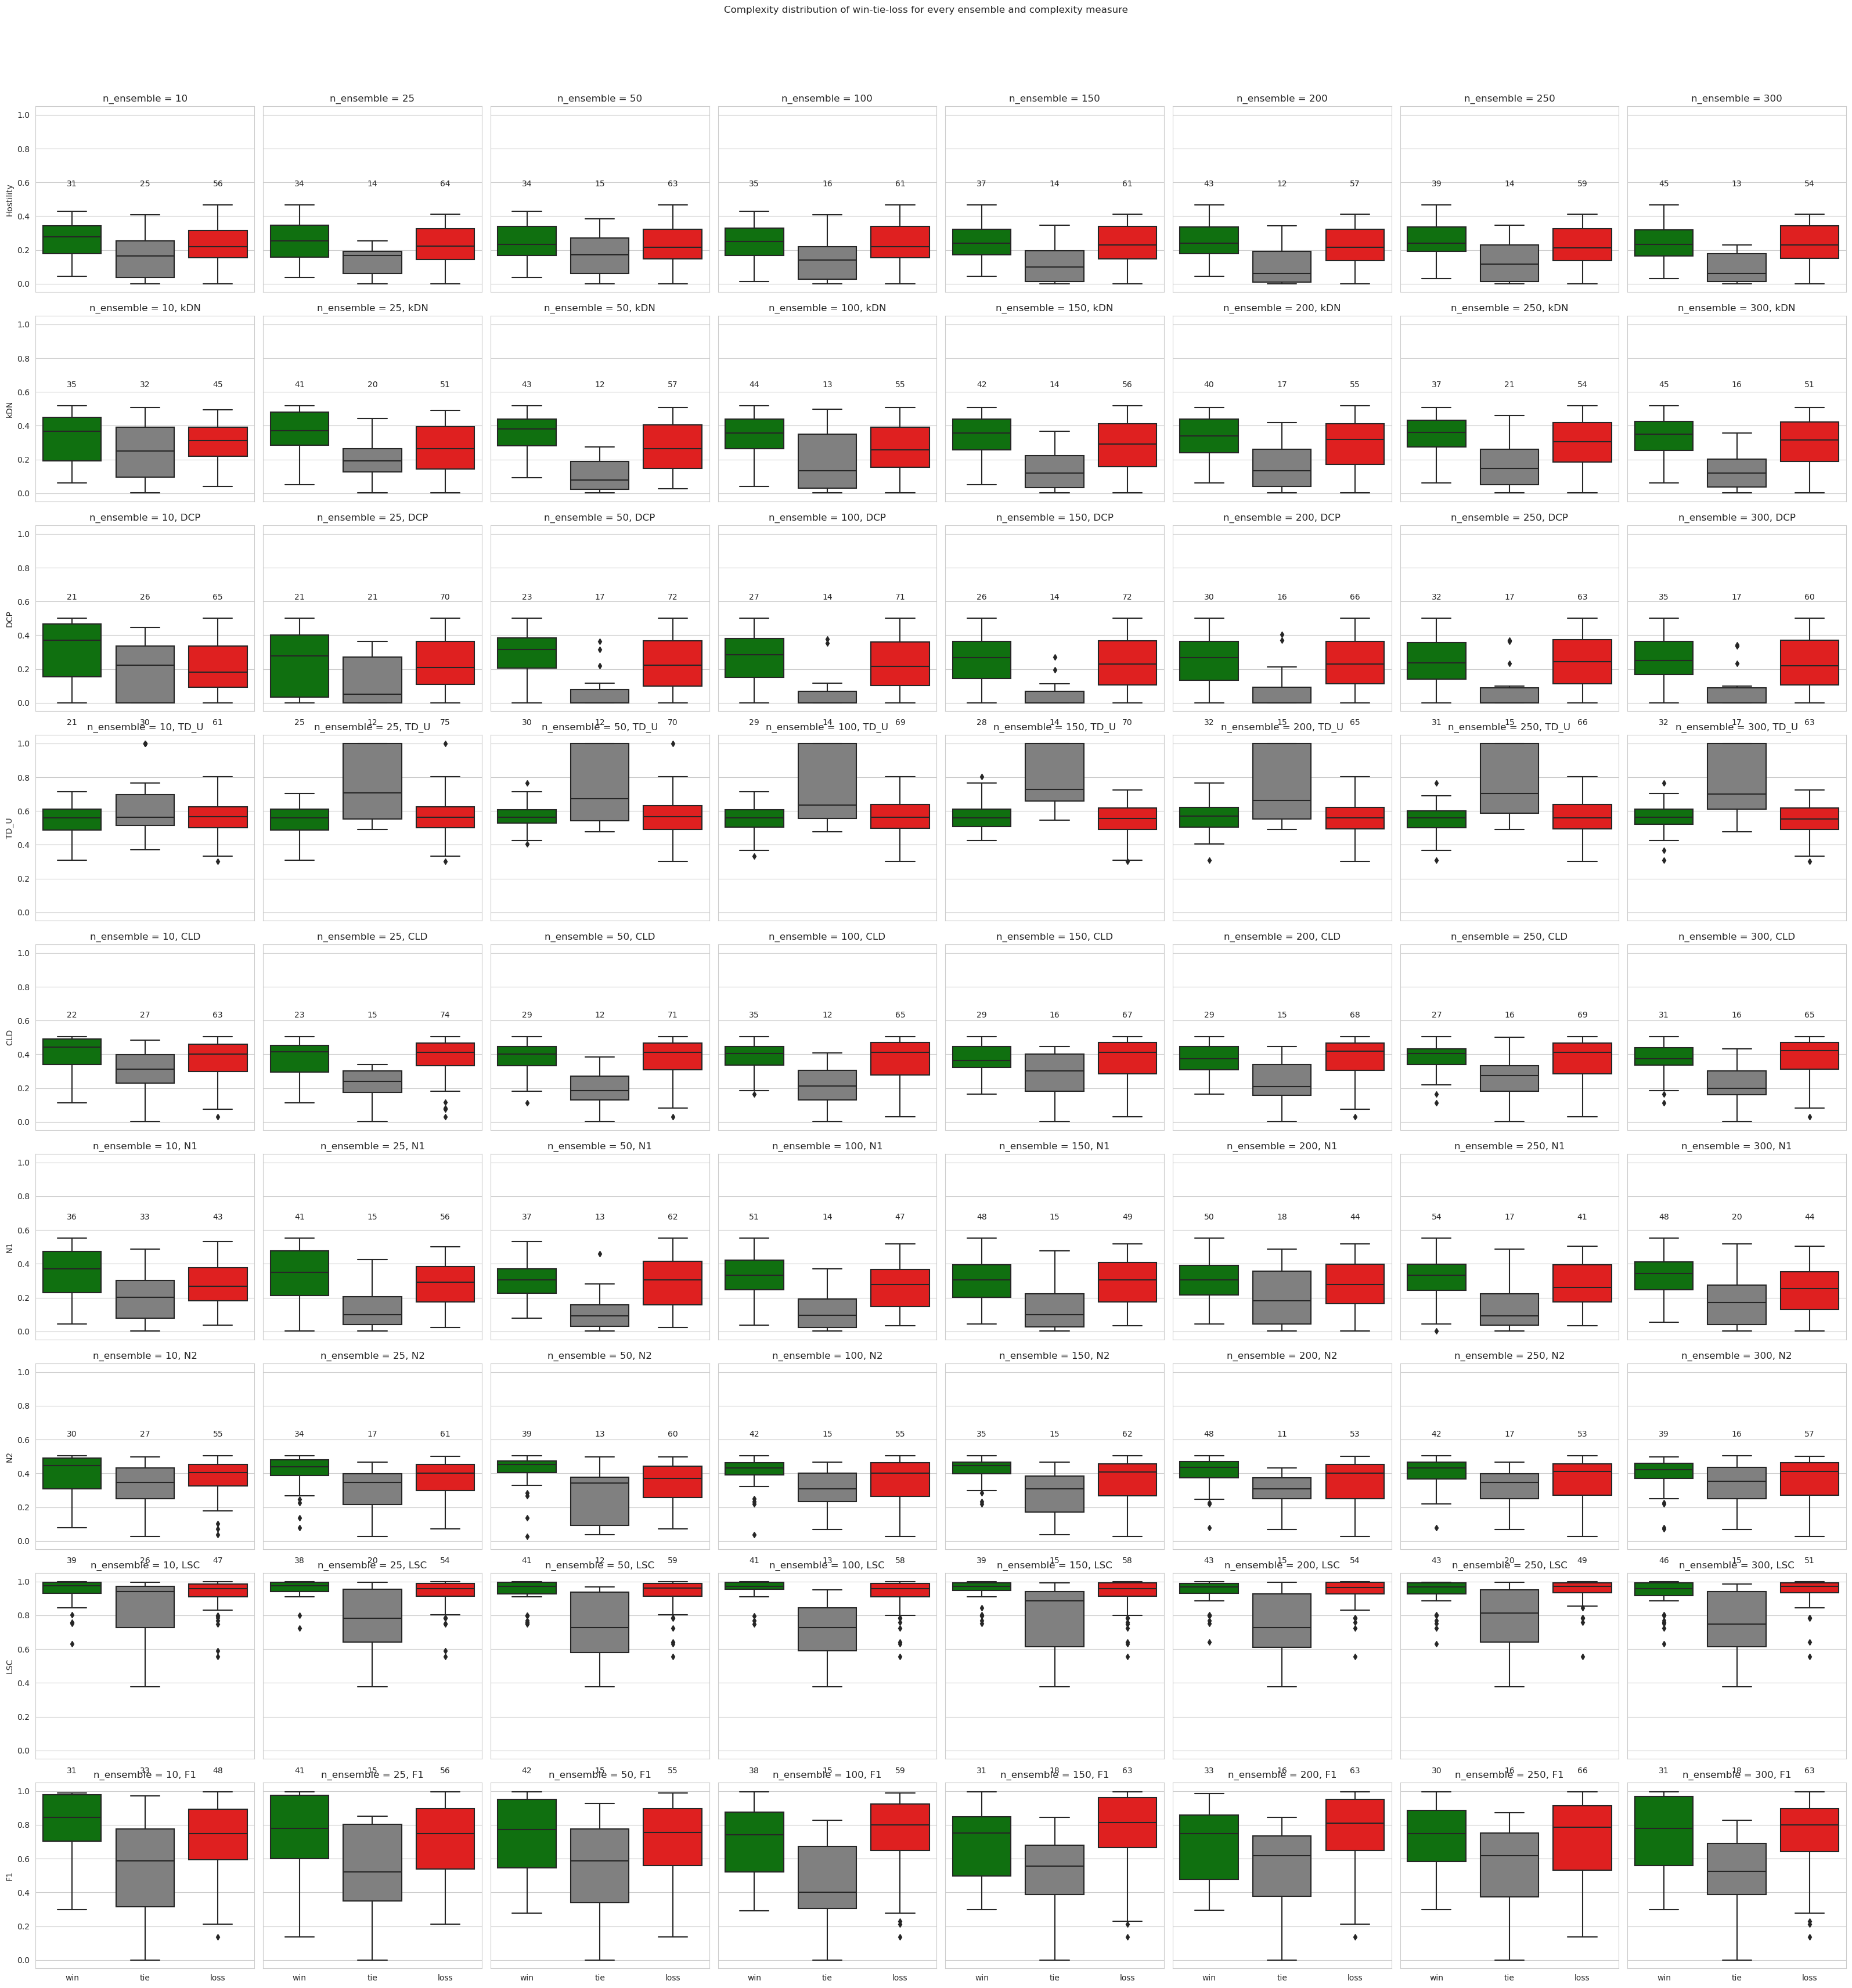

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

list_CM = ['Hostility', 'kDN', 'DCP', 'TD_U', 'CLD', 'N1', 'N2', 'LSC', 'F1']
n_ensemble_values = [10, 25, 50, 100, 150, 200, 250, 300]

# Crear la cuadrícula de gráficos
n_rows = len(list_CM)
n_cols = len(n_ensemble_values)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey=True, sharex=True)
fig.suptitle("Complexity distribution of win-tie-loss for every ensemble and complexity measure")

paleta = {'win': 'green', 'tie': 'grey', 'loss': 'red'}
orden = ['win', 'tie', 'loss']  # Orden fijo de categorías

for i, compl_measure in enumerate(list_CM):
    for j, n in enumerate(n_ensemble_values):
        # Filtrar los datos para la medida de complejidad y n_ensemble específicos
        subset = results_df[(results_df['n_ensemble'] == n) & (results_df['compl_measure'] == compl_measure)]

        # Crear el boxplot
        sns.boxplot(data=subset, x='result', y='complexity_value', ax=axes[i, j], palette=paleta, order=orden)

        # Añadir la cantidad de datos encima de cada boxplot
        counts = subset['result'].value_counts()
        for k, category in enumerate(orden):
            if category in counts:
                count = counts[category]
                axes[i, j].text(k, subset['complexity_value'].max() + 0.1,  # Ajustar posición vertical
                                str(count), ha='center', va='bottom', fontsize=10)

        axes[i, j].set_title(f'n_ensemble = {n}, {compl_measure}')
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Ajustar etiquetas generales
for ax, compl_measure in zip(axes[:, 0], list_CM):
    ax.set_ylabel(compl_measure)

for ax, n in zip(axes[0, :], n_ensemble_values):
    ax.set_title(f'n_ensemble = {n}')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Con las medidas con rangos difíciles de interpretar no se aclara nada. Pero con las fáciles de interrpetar (N1, kdn, hostility, n2) sí se aprecia que para los datatasets difíciles es mejor darle peso a lo fácil. Lo que pasa es que no está super claro. Voy a probar a hacer un filtro más exhaustivo de lo que se considera "dataset difícil" mezclando las medidas de complejidad para las que parece que la cosa funciona. Puedo intentar conseguir más datasets difíciles

In [93]:
# Lo hacemos con los pesos difíciles
win_tie_loss_df, all_results = win_tie_loss_comparison_info_complexity(all_datasets, df_complex, loss_function='exponential', main_method='classic', compare_method='sample_weight_hard')


In [94]:
results_df = pd.DataFrame(all_results)
results_df

,n_ensemble,compl_measure,result,complexity_value,dataset_name,classic,sample_weight_hard
0,10,Hostility,tie,0.229730,analcatdata_gviolence,0.971429,0.971429
1,10,Hostility,loss,0.181481,heart-statlog,0.818519,0.770370
2,10,Hostility,loss,0.337098,diabetic_retinopathy,0.645525,0.576867
3,10,Hostility,win,0.214286,hutsof99_logis,0.728571,0.742857
4,10,Hostility,loss,0.342900,disclosure_x_bias,0.522614,0.459204
...,...,...,...,...,...,...,...
8059,300,F1,tie,0.828231,bodyfat,0.996000,0.996000
8060,300,F1,loss,0.889940,vehicle2,0.972801,0.968025
8061,300,F1,win,0.986908,disclosure_x_tampered,0.500158,0.525893
8062,300,F1,win,0.744147,boston,0.881255,0.887137


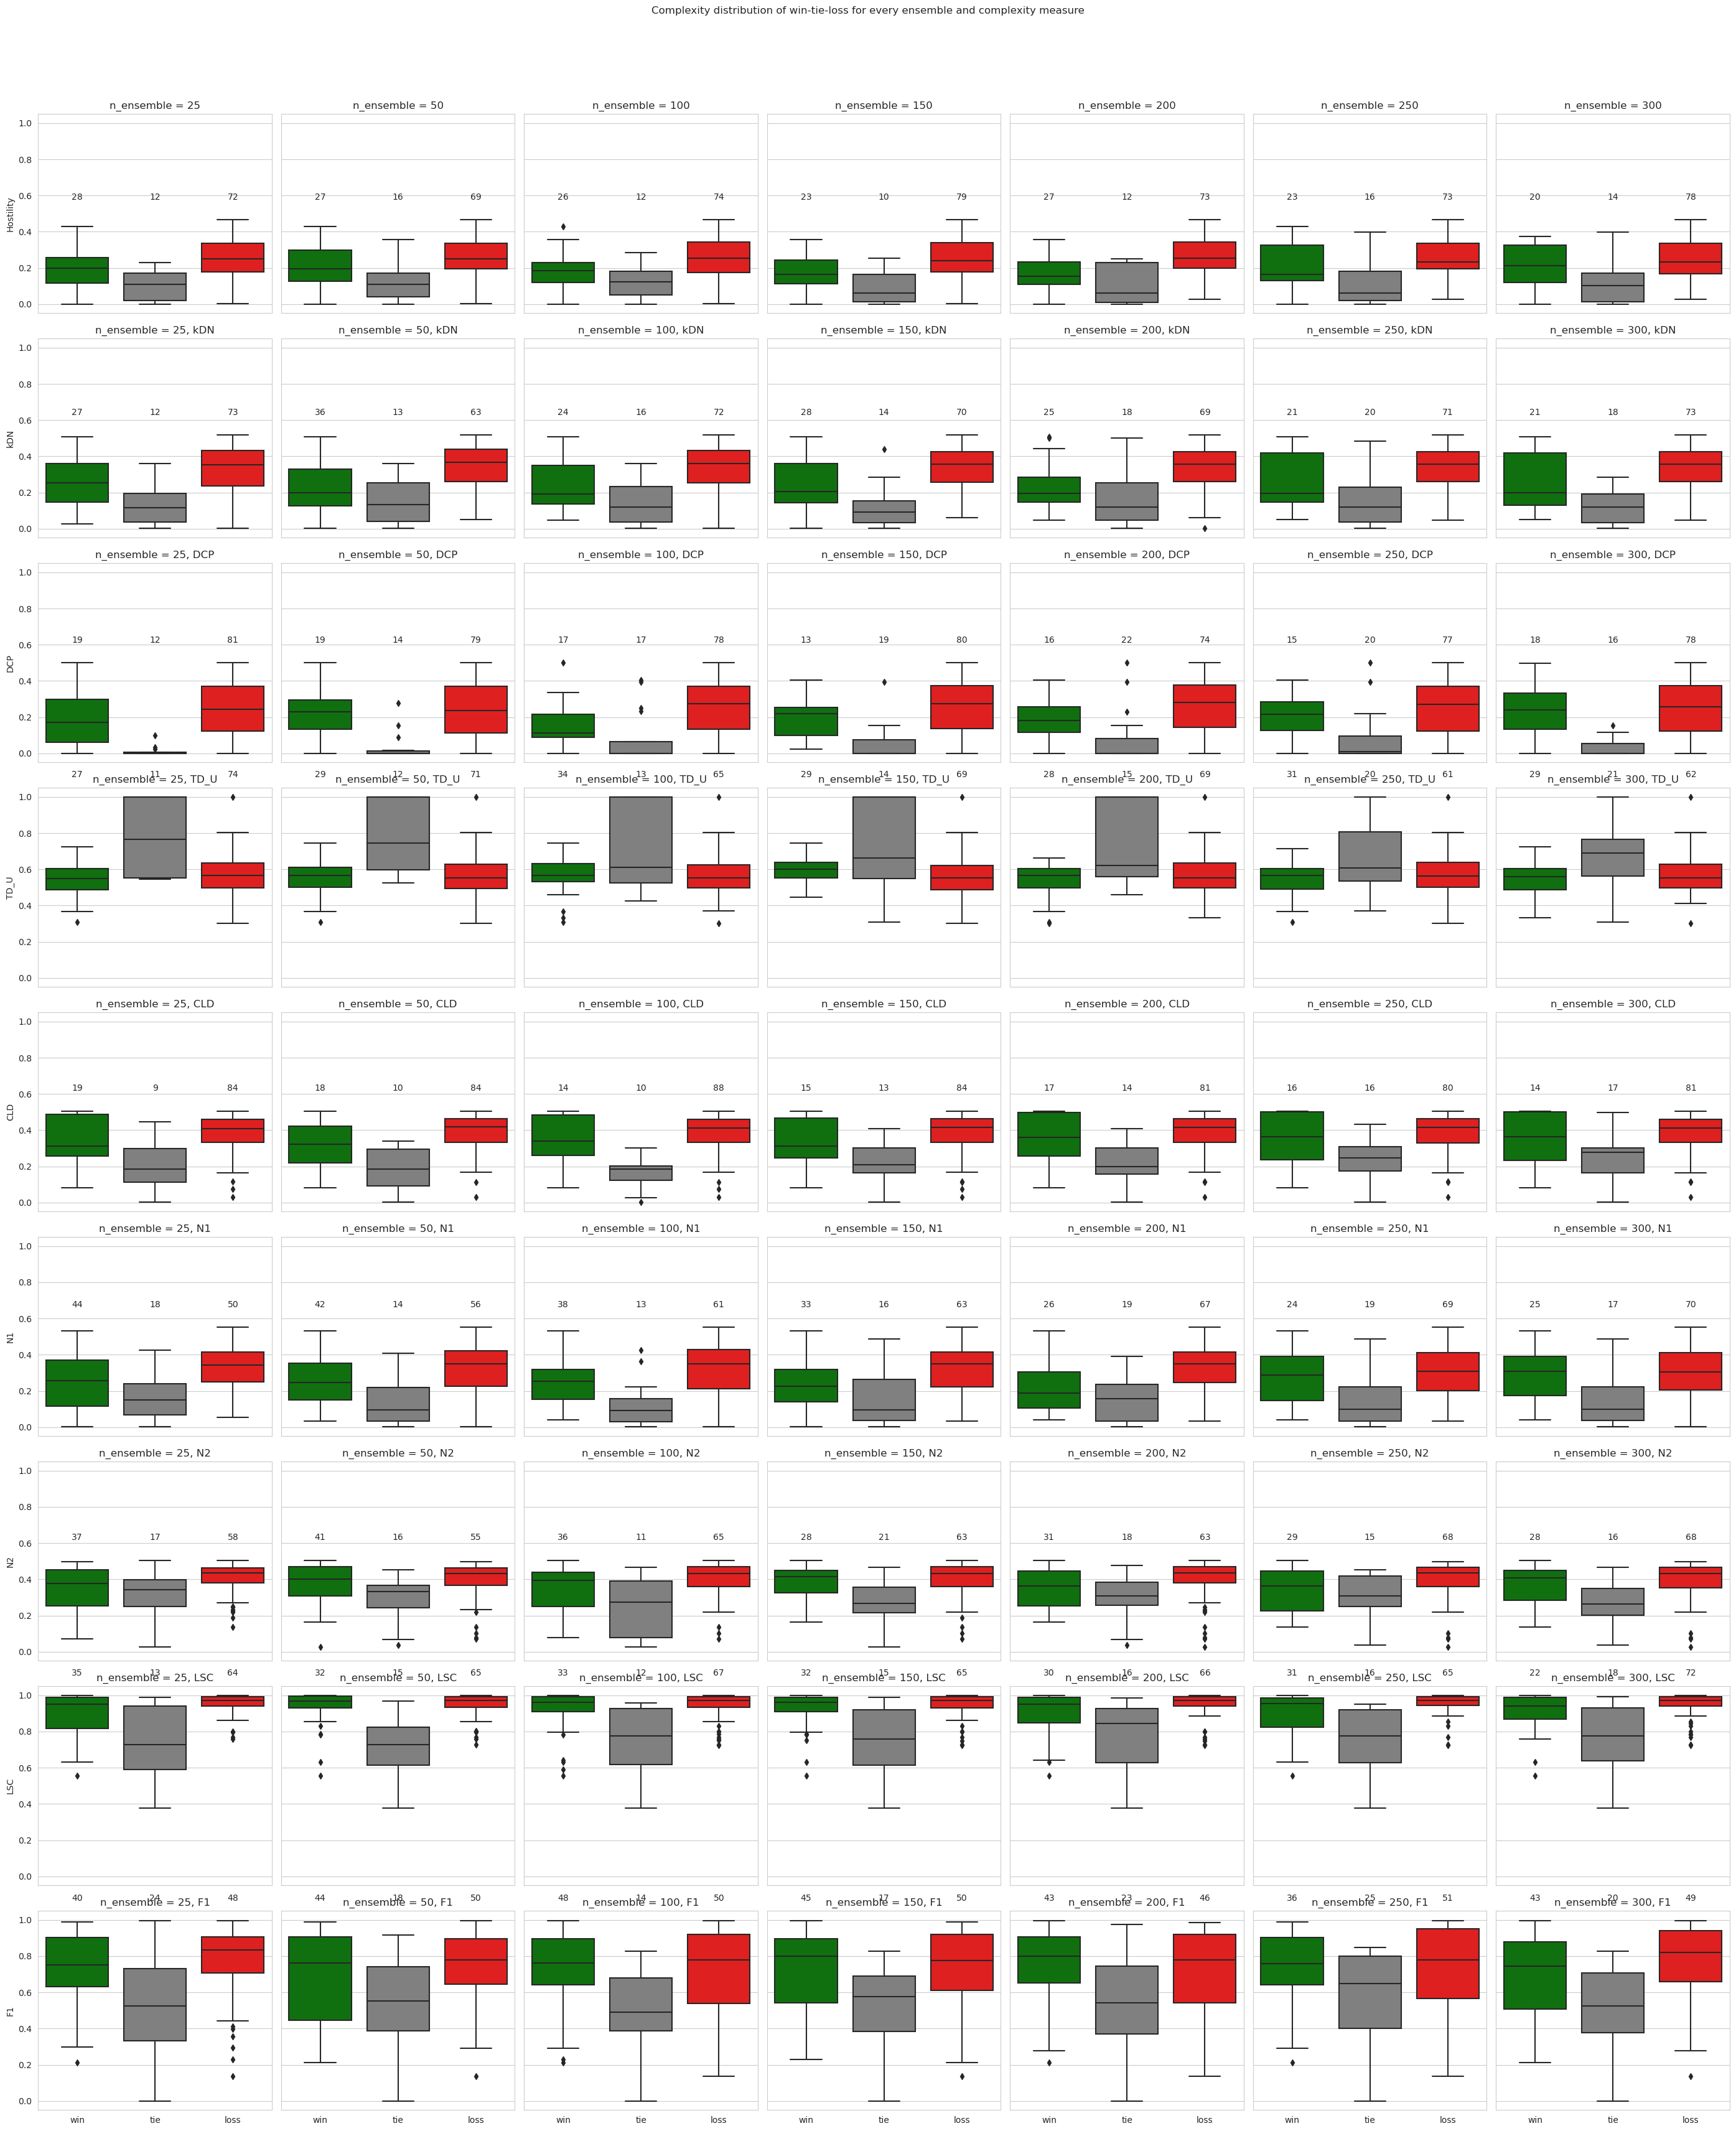

In [95]:

list_CM = ['Hostility', 'kDN', 'DCP', 'TD_U', 'CLD', 'N1', 'N2', 'LSC', 'F1']
n_ensemble_values = [25, 50, 100, 150, 200, 250, 300]

# Crear la cuadrícula de gráficos
n_rows = len(list_CM)
n_cols = len(n_ensemble_values)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharey=True, sharex=True)
fig.suptitle("Complexity distribution of win-tie-loss for every ensemble and complexity measure")

paleta = {'win': 'green', 'tie': 'grey', 'loss': 'red'}
orden = ['win', 'tie', 'loss']  # Orden fijo de categorías

for i, compl_measure in enumerate(list_CM):
    for j, n in enumerate(n_ensemble_values):
        # Filtrar los datos para la medida de complejidad y n_ensemble específicos
        subset = results_df[(results_df['n_ensemble'] == n) & (results_df['compl_measure'] == compl_measure)]

        # Crear el boxplot
        sns.boxplot(data=subset, x='result', y='complexity_value', ax=axes[i, j], palette=paleta, order=orden)

        # Añadir la cantidad de datos encima de cada boxplot
        counts = subset['result'].value_counts()
        for k, category in enumerate(orden):
            if category in counts:
                count = counts[category]
                axes[i, j].text(k, subset['complexity_value'].max() + 0.1,  # Ajustar posición vertical
                                str(count), ha='center', va='bottom', fontsize=10)

        axes[i, j].set_title(f'n_ensemble = {n}, {compl_measure}')
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Ajustar etiquetas generales
for ax, compl_measure in zip(axes[:, 0], list_CM):
    ax.set_ylabel(compl_measure)

for ax, n in zip(axes[0, :], n_ensemble_values):
    ax.set_title(f'n_ensemble = {n}')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Cuando el conjunto de datos es difícil, es mejor darle más peso a lo fácil. Cuando es fácil, es mejor darle más peso a lo difícil. Tendría que estudiar también quién consigue un resultado mayor antes (o al menos con diferencia significativa)


**"Conclusión por ahora"**

 * Medidas que aparcamos por ahora debido a la dificultad a la hora de interpretar el rango y, por tanto, realizar categorizaciones: LSC, valores muy concentrados en 0.9, muy difícil de interpretar. TD_U por tema de categorización y porque aporta la misma información que boosting. F1 por la categorización y por los resultados. CLD por la categorización y por los resultados.


 * N2: mejorar la categorización porque hay luz al fondo del tunel. Hacerlo en función de otras medidas de complejidad.

 * Hostility; investigar un poco más
 * DCP investigar un poco más con easy x2 a ver si sacamos algo

 * kDN y N1 son los que mejores resultados ofrecen. Hacer una categorización general de complejidad de datasets en función de distintas medidas de complejidad y ver ahí cómo funcionan las cosas

 * Obtener aun más datos

 * Algún estudio de estabilidad para ver quién logra el mejor resultado y cuándo. Ver quién se degrada más.

 * Sacar WTL de los x2 para completar el análisis
